In [4]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [3]:
def df_gen(RESULTS_DIR, NSHARDS = 10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [4]:
def plot_model_perf_vs_feature_noise_dim(dfs, models, metric, noise_feature_dims):
    plot_data = []
    for i, df in enumerate(dfs):
        # Select the metric columns for the models
        df_copy = df[[f'{model}__{metric}' for model in models]].copy()
        # Add the feature dimension column
        df_copy['feature_dim'] = noise_feature_dims[i]
        plot_data.append(df_copy)

    combined_df_wide = pd.concat(plot_data, ignore_index=True)


    # --- 3. Reshape Data from Wide to Long Format ---
    # This is the key step. We use `pd.melt` to turn the model columns
    # into rows, making the data suitable for seaborn's `hue` parameter.

    id_vars = ['feature_dim']
    value_vars = [f'{model}__{metric}' for model in models]

    combined_df_long = pd.melt(
        combined_df_wide,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='model_metric', # New column for the original column names
        value_name='performance_score' # New column for the performance values
    )

    # Clean up the model names (e.g., 'GCN__test_rocauc_ovr' -> 'GCN')
    combined_df_long['model'] = combined_df_long['model_metric'].str.replace(f'__{metric}', '', regex=False)


    # --- 4. Create the Combined Boxplot ---
    # Now we create a single plot, using `hue` to differentiate the models.

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.boxplot(
        x='feature_dim',
        y='performance_score',
        hue='model', # This tells seaborn to use different colors for each model
        data=combined_df_long,
        ax=ax,
        palette='muted' # A nice color palette
    )

    # --- 5. Customize and Show the Plot ---
    ax.set_title(f'Model Performance ({metric}) vs. Noise Feature Dimension', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Noise Features', fontsize=12)
    ax.set_ylabel('Performance Score (ROC AUC)', fontsize=12)
    ax.legend(title='Model') # Add a legend to identify the colors

    plt.tight_layout()
    plt.show()

In [5]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/1'
df = df_gen(RESULTS_DIR = RESULTS_DIR) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [6]:
plot_model_perf_vs_feature_noise_dim([df], models = ['MLP', 'HGCN', 'GCN'], metric = 'test_rocauc_ovr', noise_feature_dims=[0])

KeyError: "['HGCN__test_rocauc_ovr', 'GCN__test_rocauc_ovr'] not in index"

In [ ]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/'
df75 = df_gen(RESULTS_DIR + '/0.75var')
df5 = df_gen(RESULTS_DIR + '/0.5var')
df2 = df_gen(RESULTS_DIR + '/0.2var')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


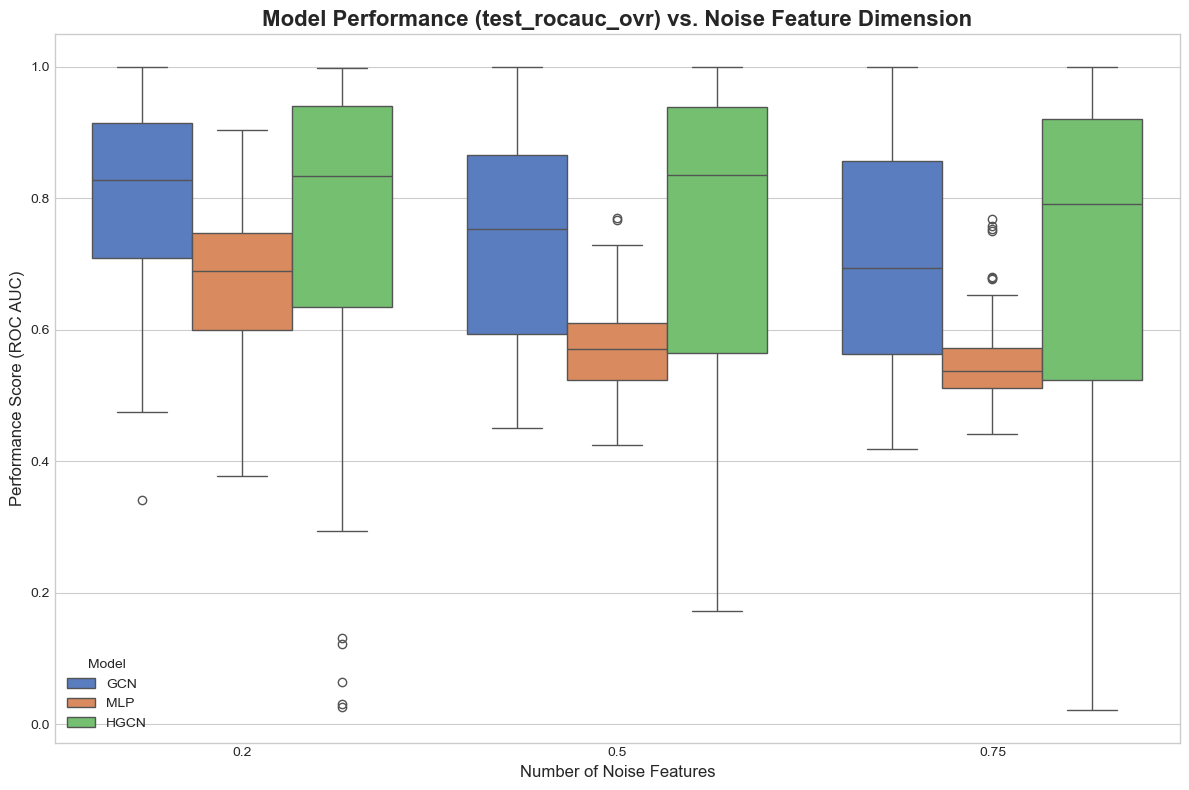

In [ ]:
plot_model_perf_vs_feature_noise_dim(dfs = [df75, df5, df2], metric=metric, models = models, noise_feature_dims = [.75, .5, .2])

## Visualizing ablations

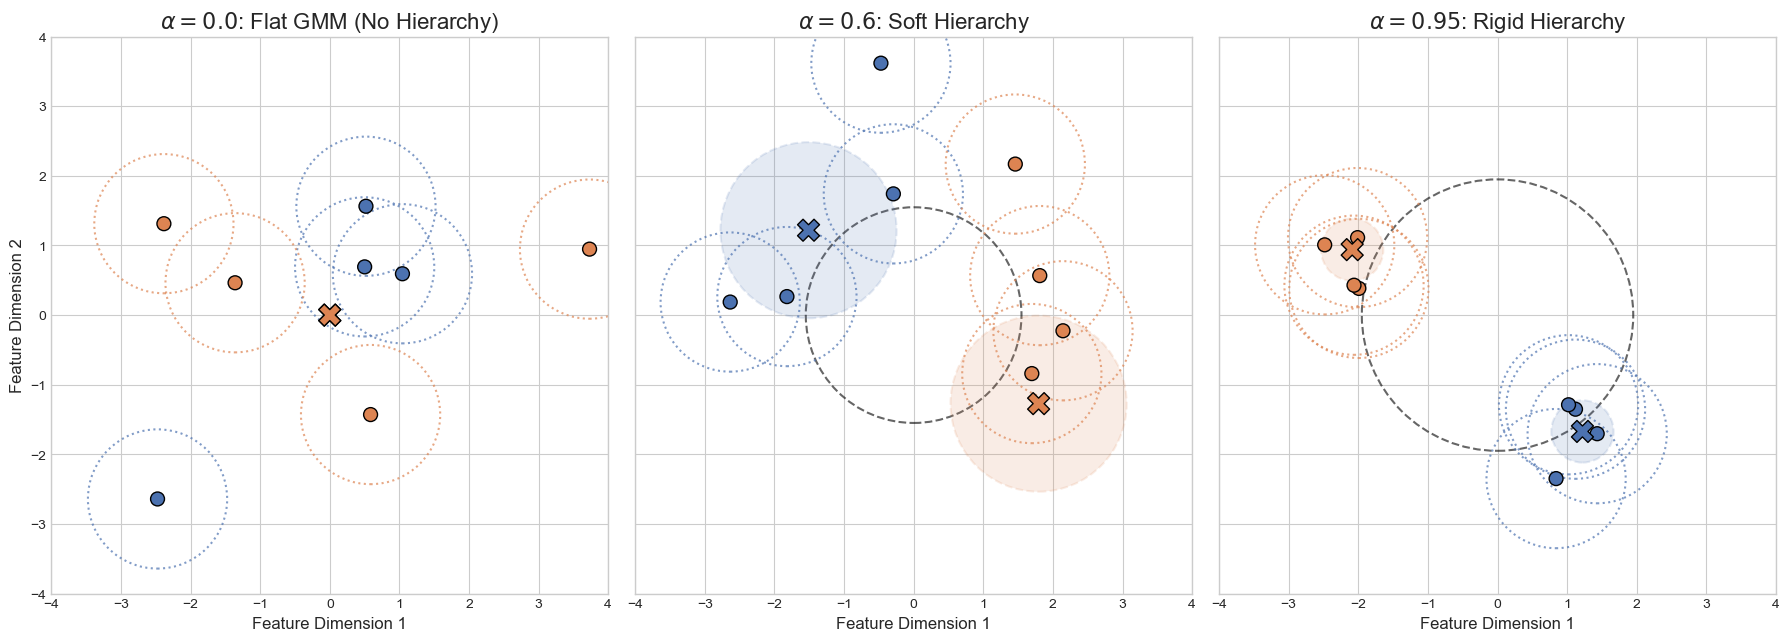

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# --- Parameters for the visualization ---
K = 8  # Total number of classes (sub-clusters)
G = 2  # Number of super-clusters
D = 2  # Feature dimension (we use 2D for plotting)
d_squared = 4.0  # Base distance (variance of centers)
node_noise_variance = 1.0 # The variance for the final node features

# Assign classes to super-groups and set colors
class_to_super = np.array([i // (K // G) for i in range(K)])
colors = sns.color_palette('deep', G)
class_colors = [colors[g] for g in class_to_super]

def generate_hierarchical_centroids(alpha, K, G, D, d_squared, class_to_super):
    """
    Generates class centroids based on the hierarchical model.
    Returns both class means and the super means used to create them.
    """
    tau_top_var = alpha * d_squared
    tau_class_var = (1 - alpha) * d_squared
    
    # Using a fixed seed here just for this specific visualization's consistency
    mu_top = np.random.multivariate_normal(
        mean=np.zeros(D), cov=np.identity(D) * tau_top_var, size=G)
    
    mu_class = np.zeros((K, D))
    for k in range(K):
        parent_super_mean = mu_top[class_to_super[k]]
        mu_class[k, :] = np.random.multivariate_normal(
            mean=parent_super_mean, cov=np.identity(D) * tau_class_var)
        
    return mu_class, mu_top

# --- Create the plot ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
alphas_to_plot = [0.0, 0.6, 0.95]
titles = [
    r'$\alpha = 0.0$: Flat GMM (No Hierarchy)',
    r'$\alpha = 0.6$: Soft Hierarchy',
    r'$\alpha = 0.95$: Rigid Hierarchy'
]

for i, alpha in enumerate(alphas_to_plot):
    ax = axes[i]
    
    centroids, mu_top = generate_hierarchical_centroids(
        alpha, K, G, D, d_squared, class_to_super
    )
    
    # Draw reference circle for super-group sampling
    tau_top_std = np.sqrt(alpha * d_squared)
    origin_circle = Circle((0, 0), tau_top_std, color='k', linestyle='--', fill=False, lw=1.5, alpha=0.6)
    ax.add_patch(origin_circle)

    # Draw reference circles for sub-group sampling
    if alpha > 0:
        tau_class_std = np.sqrt((1.0 - alpha) * d_squared)
        for g in range(G):
            super_mean_circle = Circle(mu_top[g], tau_class_std, color=colors[g], linestyle='--', 
                                       fill=True, lw=1.5, alpha=0.15)
            ax.add_patch(super_mean_circle)

    # --- ADDED: Draw circles of unit variance around each sub-cluster center ---
    node_noise_std = np.sqrt(node_noise_variance)
    for k in range(K):
        center = centroids[k]
        # Use a fine dotted line for this final level of variance
        node_noise_circle = Circle(center, node_noise_std, edgecolor=class_colors[k], 
                                   linestyle=':', fill=False, lw=1.5, alpha=0.7)
        ax.add_patch(node_noise_circle)

    # Plot the class centroids (dots) and super-group means (X's)
    ax.scatter(centroids[:, 0], centroids[:, 1], c=class_colors, s=100, alpha=1.0, edgecolors='k', zorder=10)
    ax.scatter(mu_top[:, 0], mu_top[:, 1], c=colors, s=250, marker='X', edgecolors='k', zorder=10)

    ax.set_title(titles[i], fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Feature Dimension 1', fontsize=12)
    ax.set_ylabel('Feature Dimension 2' if i == 0 else '', fontsize=12)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

# fig.suptitle('Visualisation of Class Centroid Geometry as Hierarchy Parameter $\\alpha$ Varies', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig('hierarchical_feature_space_full_variance.png', dpi=300, bbox_inches='tight')
plt.show()

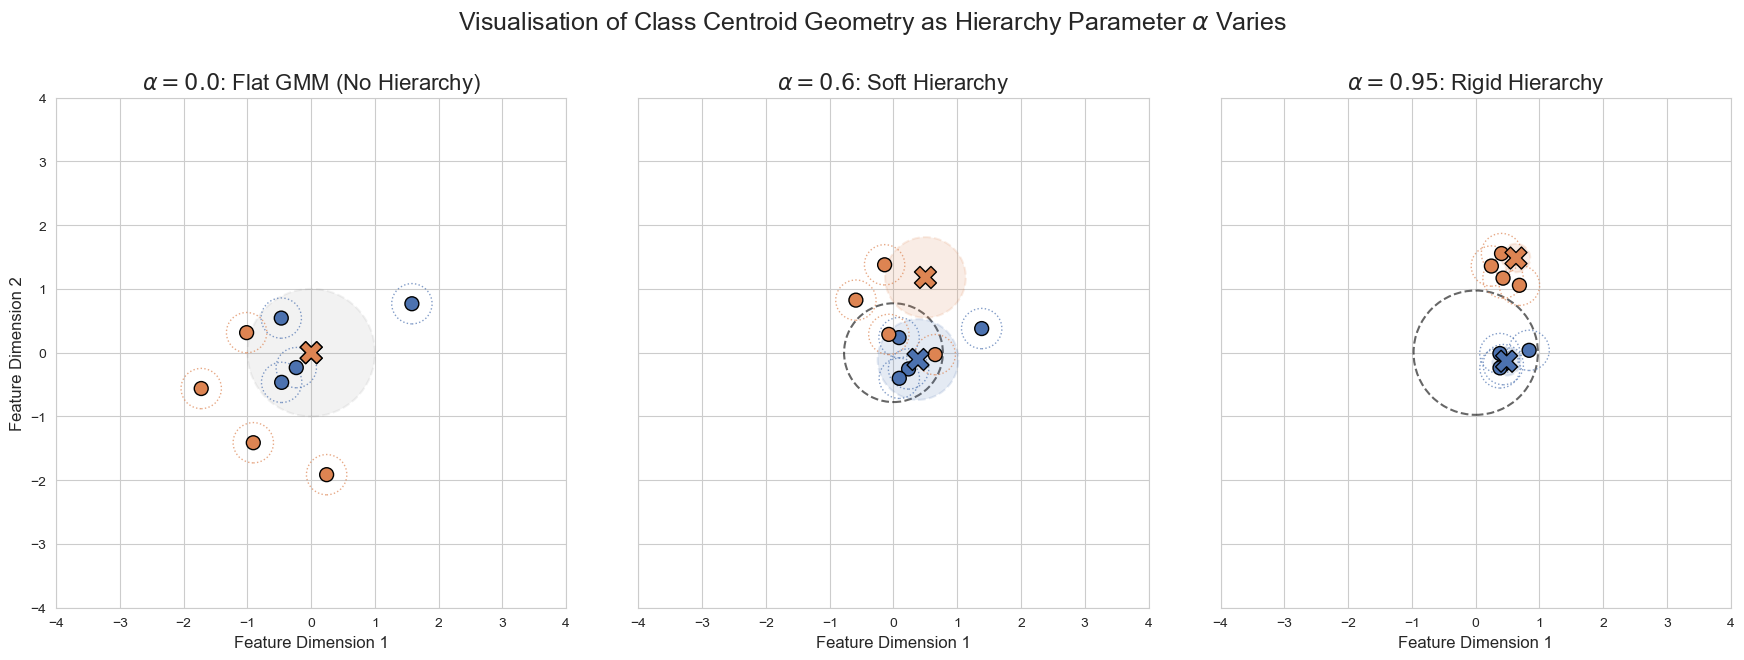

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# --- Parameters for the visualization ---
K = 8  # Total number of classes (sub-clusters)
G = 2  # Number of super-clusters
D = 2  # Feature dimension (we use 2D for plotting)
d_squared = 1.0  # Base distance (variance of centers)
node_noise_variance = 0.1 # The variance for the final node features

# Assign classes to super-groups and set colors
class_to_super = np.array([i // (K // G) for i in range(K)])
colors = sns.color_palette('deep', G)
class_colors = [colors[g] for g in class_to_super]

def generate_hierarchical_centroids(alpha, K, G, D, d_squared, class_to_super):
    """
    Generates class centroids based on the hierarchical model.
    Returns both class means and the super means used to create them.
    """
    tau_top_var = alpha * d_squared
    tau_class_var = (1 - alpha) * d_squared
    
    # Using a fixed seed for visualization consistency
    np.random.seed(42) 
    mu_top = np.random.multivariate_normal(
        mean=np.zeros(D), cov=np.identity(D) * tau_top_var, size=G)
    
    mu_class = np.zeros((K, D))
    for k in range(K):
        parent_super_mean = mu_top[class_to_super[k]]
        mu_class[k, :] = np.random.multivariate_normal(
            mean=parent_super_mean, cov=np.identity(D) * tau_class_var)
        
    return mu_class, mu_top

# --- Create the plot ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
alphas_to_plot = [0.0, 0.6, 0.95]
titles = [
    r'$\alpha = 0.0$: Flat GMM (No Hierarchy)',
    r'$\alpha = 0.6$: Soft Hierarchy',
    r'$\alpha = 0.95$: Rigid Hierarchy'
]

for i, alpha in enumerate(alphas_to_plot):
    ax = axes[i]
    
    centroids, mu_top = generate_hierarchical_centroids(
        alpha, K, G, D, d_squared, class_to_super
    )
    
    # --- CORRECTED LOGIC FOR PLOTTING REFERENCE CIRCLES ---
    if alpha == 0:
        # For the flat case, draw one circle at the origin representing the total variance
        # from which all sub-clusters are sampled.
        std_dev = np.sqrt(d_squared)
        reference_circle = Circle((0, 0), std_dev, color='gray', linestyle='--', 
                                  fill=True, lw=1.5, alpha=0.1)
        ax.add_patch(reference_circle)
    else:
        # For hierarchical cases, draw a circle for super-group sampling...
        tau_top_std = np.sqrt(alpha * d_squared)
        origin_circle = Circle((0, 0), tau_top_std, color='k', linestyle='--', 
                               fill=False, lw=1.5, alpha=0.6)
        ax.add_patch(origin_circle)
        
        # ...and also draw circles for the sub-group sampling around each super-mean.
        tau_class_std = np.sqrt((1.0 - alpha) * d_squared)
        for g in range(G):
            super_mean_circle = Circle(mu_top[g], tau_class_std, color=colors[g], 
                                       linestyle='--', fill=True, lw=1.5, alpha=0.15)
            ax.add_patch(super_mean_circle)

    # Draw circles of unit variance around each sub-cluster center
    node_noise_std = np.sqrt(node_noise_variance)
    for k in range(K):
        center = centroids[k]
        node_noise_circle = Circle(center, node_noise_std, edgecolor=class_colors[k], 
                                   linestyle=':', fill=False, lw=1.0, alpha=0.7)
        ax.add_patch(node_noise_circle)

    # Plot the class centroids (dots) and super-group means (X's)
    ax.scatter(centroids[:, 0], centroids[:, 1], c=class_colors, s=100, alpha=1.0, edgecolors='k', zorder=10)
    ax.scatter(mu_top[:, 0], mu_top[:, 1], c=colors, s=250, marker='X', edgecolors='k', zorder=10)

    ax.set_title(titles[i], fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Feature Dimension 1', fontsize=12)
    ax.set_ylabel('Feature Dimension 2' if i == 0 else '', fontsize=12)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig.suptitle('Visualisation of Class Centroid Geometry as Hierarchy Parameter $\\alpha$ Varies', fontsize=18, y=1.05)
plt.tight_layout()
# plt.savefig('hierarchical_feature_space_final_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import sys
import os

# Get the path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(parent_dir)
# Get the path of the subdirectory containing your module
sbm_dir = os.path.join(parent_dir, 'graph_world/generators')
print(sbm_dir)
# Add the subdirectory to Python's path
if sbm_dir not in sys.path:
    sys.path.append(sbm_dir)


/Users/daniel/Documents/masters_ai/thesis/graphworld/src
/Users/daniel/Documents/masters_ai/thesis/graphworld/src/graph_world/generators


Generating Flat SBM graph...
Generating Hierarchical SBM graph...
Generating final plot...


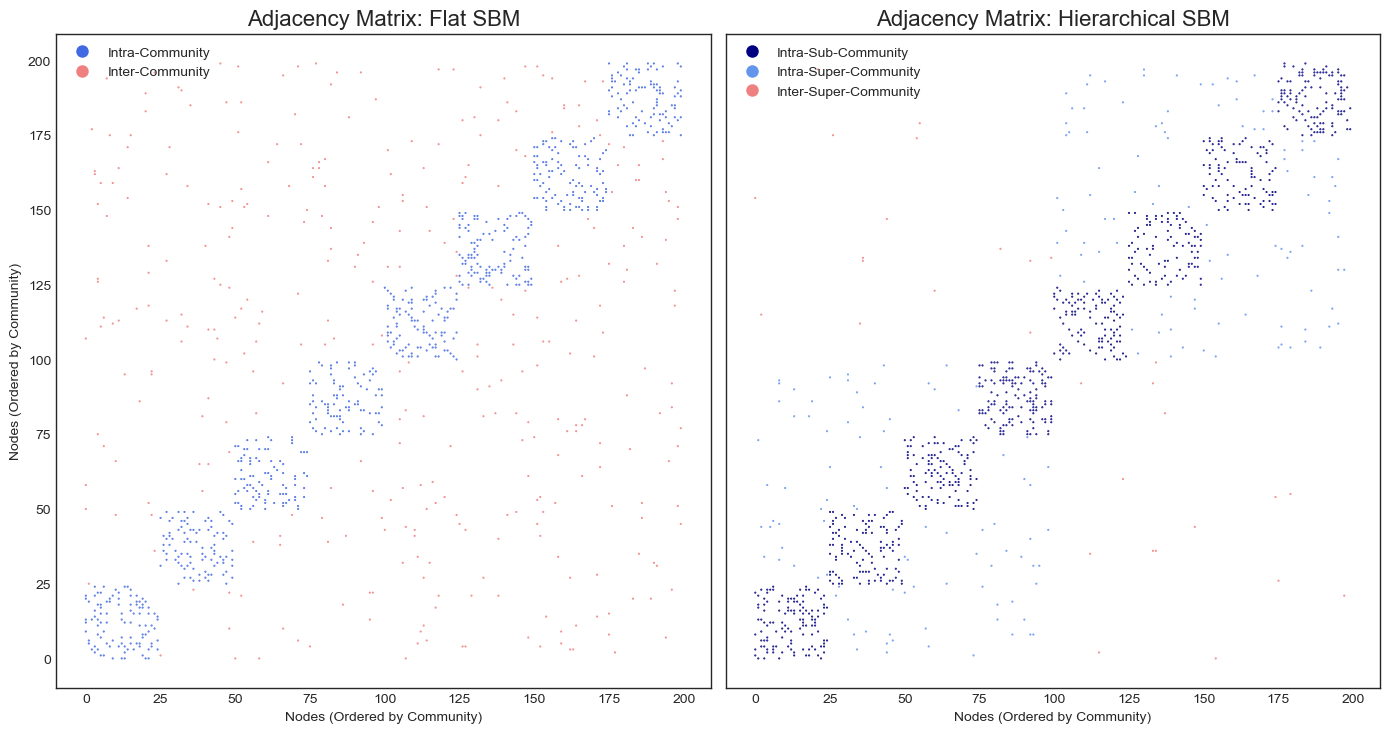

Generating networkx node-link diagrams...


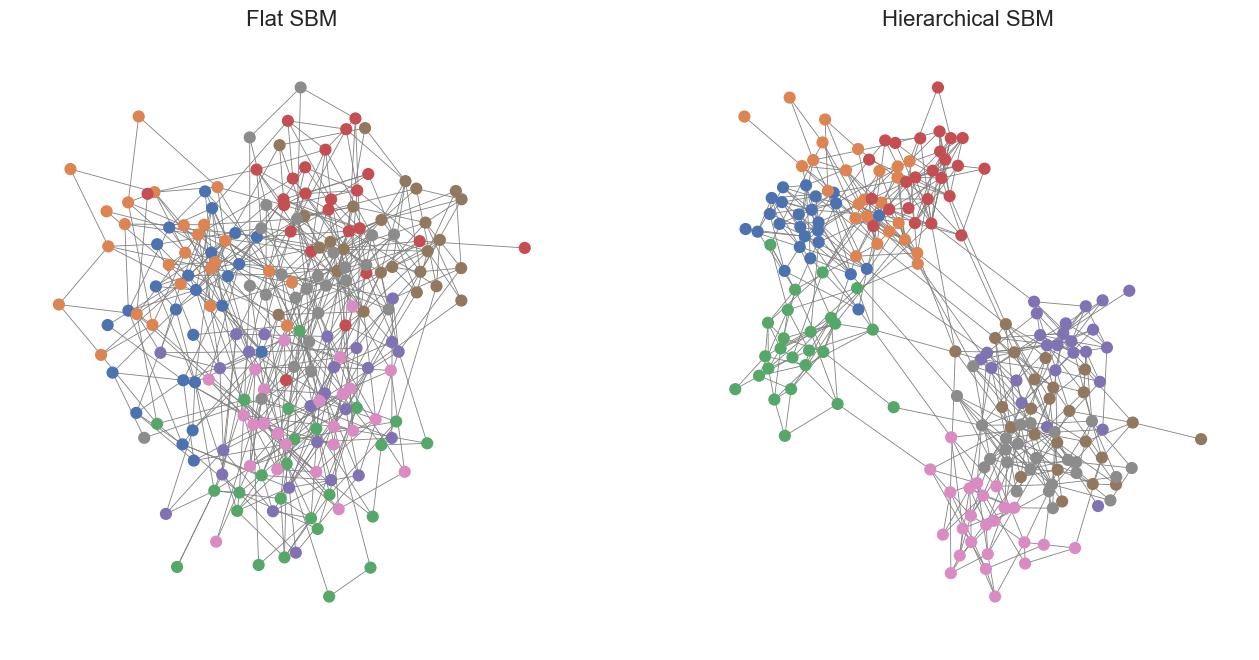

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
import networkx as nx

# Assuming your sbm_simulator.py file is in the same directory
import sbm_simulator as sbm

# --- 1. Define Common Parameters ---
N_VERTICES = 200  # A good size for this visualization
AVG_DEGREE = 12
NUM_CLUSTERS = 8 # 2 super-clusters of 4
P_TO_Q_RATIO = 15.0 # High ratio for very clear visual blocks


# --- 2. Generate the Flat SBM Graph ---
print("Generating Flat SBM graph...")
pi_flat = sbm.MakePi(NUM_CLUSTERS, community_size_slope=0.0)
prop_mat_flat = sbm.MakePropMat(NUM_CLUSTERS, P_TO_Q_RATIO)
num_edges_flat = N_VERTICES * AVG_DEGREE / 2
flat_sbm_data = sbm.StochasticBlockModel()
sbm.SimulateSbm(flat_sbm_data, N_VERTICES, num_edges_flat, pi_flat, prop_mat_flat)

# --- 3. Generate the Hierarchical SBM Graph ---
print("Generating Hierarchical SBM graph...")
p_intra_sub = 15.0
p_intra_super = 1.0
p_inter_super = 0.1
hsbm_data = sbm.StochasticBlockModel()
prop_mat_hierarchical = sbm.MakeHierarchicalPropMat(
    num_super_communities=2, subs_per_super=4,
    p_intra_sub=p_intra_sub, p_intra_super=p_intra_super, p_inter_super=p_inter_super
)
sbm.SimulateSbm(hsbm_data, N_VERTICES, num_edges_flat, pi_flat, prop_mat_hierarchical)

# --- 4. Prepare Data for Plotting ---

def get_flat_colored_edge_coords(sbm_data_object):
    """Returns coordinates and colors for a standard SBM plot (2 colors)."""
    memberships = sbm_data_object.graph_memberships
    perm_idx = np.argsort(memberships)
    pos_map = {original_id: new_pos for new_pos, original_id in enumerate(perm_idx)}

    coords = {'x': [], 'y': [], 'colors': []}
    colors_map = {'intra': 'royalblue', 'inter': 'lightcoral'}
    
    for edge in sbm_data_object.graph.edges():
        u, v = int(edge.source()), int(edge.target())
        coords['x'].extend([pos_map[u], pos_map[v]])
        coords['y'].extend([pos_map[v], pos_map[u]])
        color = colors_map['intra'] if memberships[u] == memberships[v] else colors_map['inter']
        coords['colors'].extend([color, color])
        
    return coords['x'], coords['y'], coords['colors']

def get_hierarchical_colored_edge_coords(sbm_data_object, subs_per_super):
    """Returns coordinates and colors for an hSBM plot (3 colors)."""
    memberships = sbm_data_object.graph_memberships
    perm_idx = np.argsort(memberships)
    pos_map = {original_id: new_pos for new_pos, original_id in enumerate(perm_idx)}

    coords = {'x': [], 'y': [], 'colors': []}
    colors_map = {'intra_sub': 'navy', 'intra_super': 'cornflowerblue', 'inter_super': 'lightcoral'}

    for edge in sbm_data_object.graph.edges():
        u, v = int(edge.source()), int(edge.target())
        coords['x'].extend([pos_map[u], pos_map[v]])
        coords['y'].extend([pos_map[v], pos_map[u]])
        
        sub_u, sub_v = memberships[u], memberships[v]
        super_u, super_v = sub_u // subs_per_super, sub_v // subs_per_super

        if sub_u == sub_v:
            color = colors_map['intra_sub']
        elif super_u == super_v:
            color = colors_map['intra_super']
        else:
            color = colors_map['inter_super']
        coords['colors'].extend([color, color])
            
    return coords['x'], coords['y'], coords['colors']

flat_coords = get_flat_colored_edge_coords(flat_sbm_data)
hierarchical_coords = get_hierarchical_colored_edge_coords(hsbm_data, 4)

# --- 5. Create the Visualization ---
print("Generating final plot...")
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Plot for Flat SBM
axes[0].scatter(flat_coords[0], flat_coords[1], c=flat_coords[2], s=1.0, marker='.', rasterized=True)
axes[0].set_title("Adjacency Matrix: Flat SBM", fontsize=16)
axes[0].set_xlabel("Nodes (Ordered by Community)")
axes[0].set_ylabel("Nodes (Ordered by Community)")
axes[0].set_aspect('equal', adjustable='box')
legend_flat = [
    Line2D([0], [0], marker='o', color='w', label='Intra-Community', markerfacecolor='royalblue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Inter-Community', markerfacecolor='lightcoral', markersize=10)
]
axes[0].legend(handles=legend_flat, loc='upper left')

# Plot for Hierarchical SBM
axes[1].scatter(hierarchical_coords[0], hierarchical_coords[1], c=hierarchical_coords[2], s=1.0, marker='.', rasterized=True)
axes[1].set_title("Adjacency Matrix: Hierarchical SBM", fontsize=16)
axes[1].set_xlabel("Nodes (Ordered by Community)")
axes[1].set_aspect('equal', adjustable='box')
legend_hierarchical = [
    Line2D([0], [0], marker='o', color='w', label='Intra-Sub-Community', markerfacecolor='navy', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Intra-Super-Community', markerfacecolor='cornflowerblue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Inter-Super-Community', markerfacecolor='lightcoral', markersize=10)
]
axes[1].legend(handles=legend_hierarchical, loc='upper left')


plt.tight_layout()
plt.savefig("sbm_vs_hsbm_adjacency_detailed.png") # Using PDF for vector graphics
plt.show()


# --- 3. Convert to Networkx and Prepare for Plotting ---
def convert_to_networkx(sbm_data_object):
    """Converts a graph-tool graph to a networkx graph."""
    g = nx.Graph()
    g.add_nodes_from(range(sbm_data_object.graph.num_vertices()))
    for edge in sbm_data_object.graph.edges():
        g.add_edge(int(edge.source()), int(edge.target()))
    return g

g_flat = convert_to_networkx(flat_sbm_data)
g_hierarchical = convert_to_networkx(hsbm_data)

# --- MODIFIED: Function to get ONLY the largest connected component ---
def get_largest_component_subgraph(graph, original_colors):
    """Finds the largest connected component and returns it as a subgraph with filtered colors."""
    # Find all connected components and select the largest one
    components = nx.connected_components(graph)
    largest_component = max(components, key=len)
    
    # Create the subgraph from the largest component
    subgraph = graph.subgraph(largest_component).copy()
    
    # Filter the colors to match the nodes in the subgraph
    # The subgraph preserves the original node indices, so we can access colors directly
    filtered_colors = [original_colors[i] for i in subgraph.nodes()]
            
    return subgraph, filtered_colors

palette = sns.color_palette("deep", NUM_CLUSTERS)
node_colors_flat_all = [palette[c] for c in flat_sbm_data.graph_memberships]
node_colors_hierarchical_all = [palette[c] for c in hsbm_data.graph_memberships]

g_flat_lcc, node_colors_flat = get_largest_component_subgraph(g_flat, node_colors_flat_all)
g_hierarchical_lcc, node_colors_hierarchical = get_largest_component_subgraph(g_hierarchical, node_colors_hierarchical_all)

# --- 4. Create the Visualization ---
print("Generating networkx node-link diagrams...")
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Flat SBM
pos_flat = nx.spring_layout(g_flat_lcc, seed=42)
nx.draw(g_flat_lcc, pos=pos_flat, ax=axes[0], node_color=node_colors_flat, node_size=60, width=0.6, edge_color='gray')
axes[0].set_title("Flat SBM", fontsize=16)

# Plot Hierarchical SBM
pos_hierarchical = nx.spring_layout(g_hierarchical_lcc, seed=42)
nx.draw(g_hierarchical_lcc, pos=pos_hierarchical, ax=axes[1], node_color=node_colors_hierarchical, node_size=60, width=0.6, edge_color='gray')
axes[1].set_title("Hierarchical SBM", fontsize=16)

plt.savefig("sbm_vs_hsbm_nodelink_lcc.png", dpi=300)
plt.show()

In [ ]:
# now generated with signal noise variance of .25
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/gen_params_varied/rq2'
dfs = []
for i in range(1,5):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df5 = df_gen(RESULTS_DIR + '/5/5')
dfs.append(df5)
df = pd.concat(dfs)
df = df.reset_index(drop=True) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

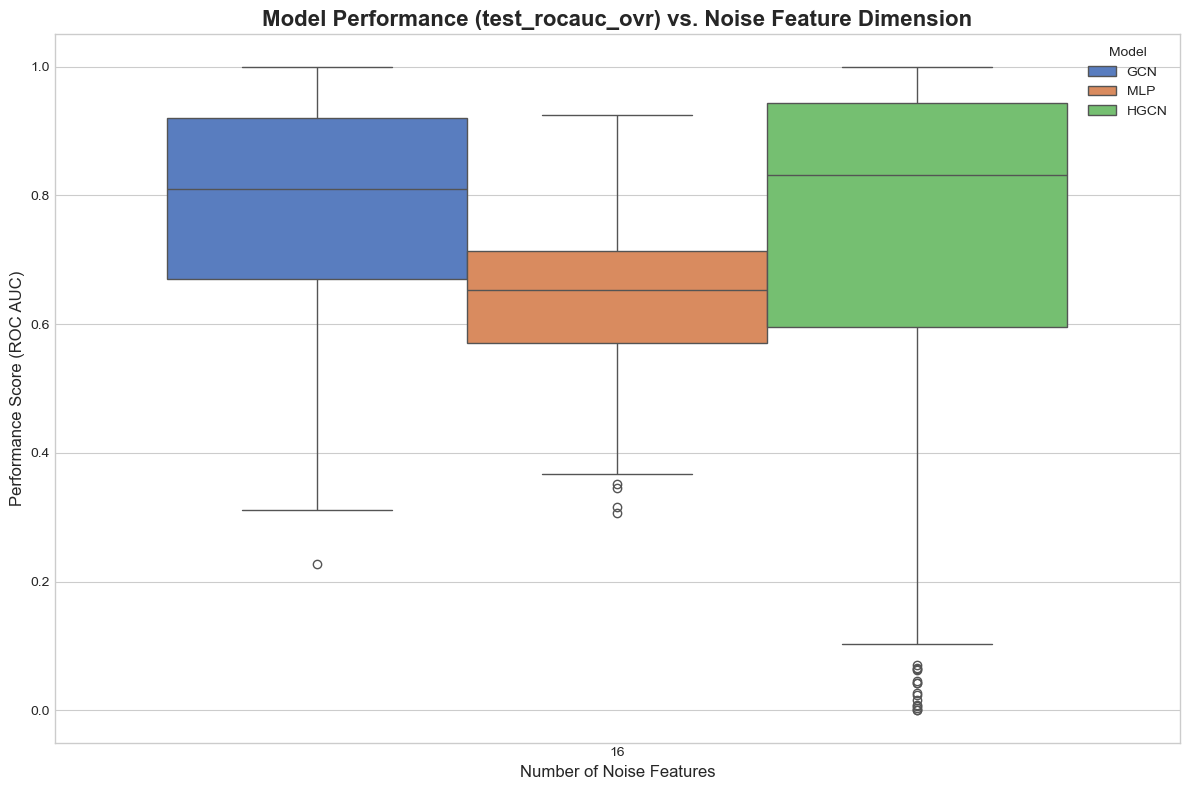

In [ ]:
plot_model_perf_vs_feature_noise_dim([df], models, metric, noise_feature_dims=[16])

In [ ]:
df[df['num_clusters'] == 8][graph_metrics_refined].describe()

,nvertex,avg_degree,degree_gini,p_to_q_ratio,num_clusters,community_size_simpsons,feature_center_distance,avg_cc,power_exponent,min_deg
count,295.000000,295.000000,295.000000,295.000000,295.0,295.000000,295.000000,295.000000,295.000000,295.000000
mean,2517.952542,14.949463,0.524298,8.675997,8.0,0.143725,0.962288,0.092158,1.640612,10.423729
std,860.391861,7.648235,0.101109,4.336788,0.0,0.009650,0.600605,0.074484,0.813178,5.204013
min,1026.000000,2.471256,0.337729,1.135035,8.0,0.125022,0.001966,0.001861,0.209948,2.000000
25%,1742.000000,7.986411,0.434085,5.142415,8.0,0.136240,0.435837,0.031511,0.950744,6.000000
50%,2532.000000,15.128873,0.520514,8.582148,8.0,0.145581,0.931724,0.073094,1.666601,11.000000
75%,3235.000000,21.004025,0.604974,12.537609,8.0,0.151797,1.514386,0.134337,2.390747,15.000000
max,4089.000000,31.693222,0.758348,15.955652,8.0,0.157240,1.993897,0.369299,2.995134,19.000000


In [33]:
def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)


    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.ylim(0,1)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def smoothed_plot_multiple_perfs_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_measures: list[str],
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (9, 6),
    cmap: str = 'tab10'
):
    """
    Plots multiple performance measures vs. a single metric on one plot,
    with shaded 95% confidence intervals.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model and perf_meas,
        a column named model+'__'+perf_meas (e.g. 'GCN__rocauc_ovr').
    models : list of str
        Model-name prefixes.
    perf_measures : list of str
        Performance-measure suffixes to plot on the y-axis.
    metric : str
        The single continuous metric to plot on the x-axis.
    n_bins : int, default=10
        Number of equal-sized bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Set up a single plot
    plt.figure(figsize=figsize)
    ax = plt.gca()

    # 2. Bin the data once based on the single metric
    try:
        df['_bin'] = pd.qcut(df[metric], q=n_bins, duplicates='drop')
    except ValueError:
        print(f"Error: Could not create {n_bins} bins for '{metric}'. Aborting plot.")
        df.drop(columns=['_bin'], inplace=True, errors='ignore')
        return

    # 3. Prepare colors for models and linestyles for performance measures
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))
    linestyles = ['-', '--', ':', '-.'] * (len(perf_measures) // 4 + 1)

    # 4. Loop through models and performance measures to plot all lines
    for model, color in zip(models, colors):
        for perf_meas, linestyle in zip(perf_measures, linestyles):
            col = f"{model}__{perf_meas}"
            if col not in df.columns:
                print(f"Warning: Column '{col}' not found. Skipping.")
                continue

            grp = df.groupby('_bin')[col]
            
            x = [b.mid for b in grp.groups.keys()]
            
            count = grp.count()
            mean = grp.mean()
            std = grp.std(ddof=1)
            sem = std / np.sqrt(count)
            ci95 = 1.96 * sem

            valid = count > 1
            if not valid.any(): continue
            
            sorted_indices = np.argsort(x)
            x_sorted = np.array(x)[sorted_indices]
            y_sorted = mean.values[sorted_indices]
            ci95_sorted = ci95.values[sorted_indices]
            
            lower = y_sorted - ci95_sorted
            upper = y_sorted + ci95_sorted

            # Plot using model-specific color and metric-specific linestyle
            ax.plot(x_sorted, y_sorted, label=f"{model} ({perf_meas})",
                    color=color, linestyle=linestyle, linewidth=2)
            ax.fill_between(x_sorted, lower, upper, color=color, alpha=0.15)
            
    # 5. Final styling
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_ylabel("Performance Score")
    ax.set_title(f"Model Performance vs. {metric.replace('_', ' ').title()}")
    ax.legend(title="Model (Metric)", bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True, errors='ignore')

In [ ]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

graph_metrics_refined = ['nvertex', 'avg_degree', 'degree_gini', 'p_to_q_ratio',
              'community_size_simpsons', 'feature_center_distance',
                 'avg_cc', 'power_exponent', 'min_deg']

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

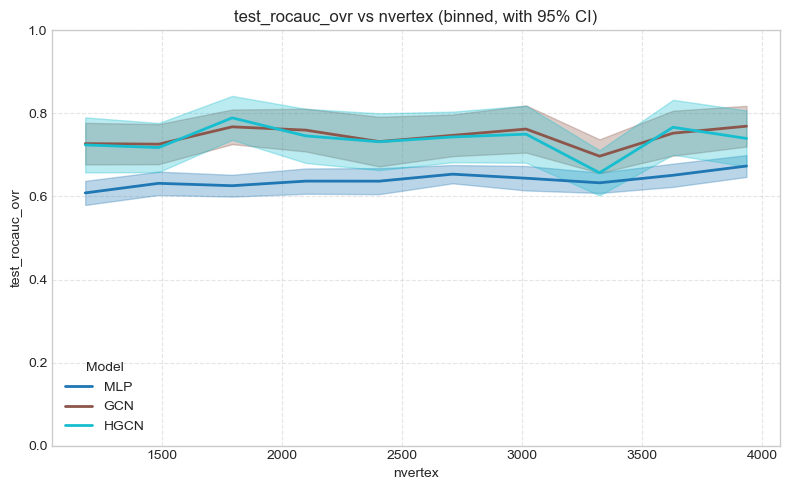

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

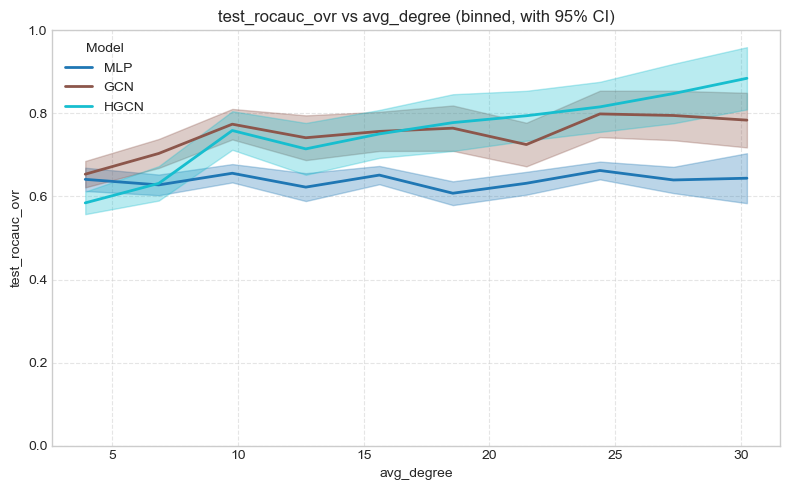

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

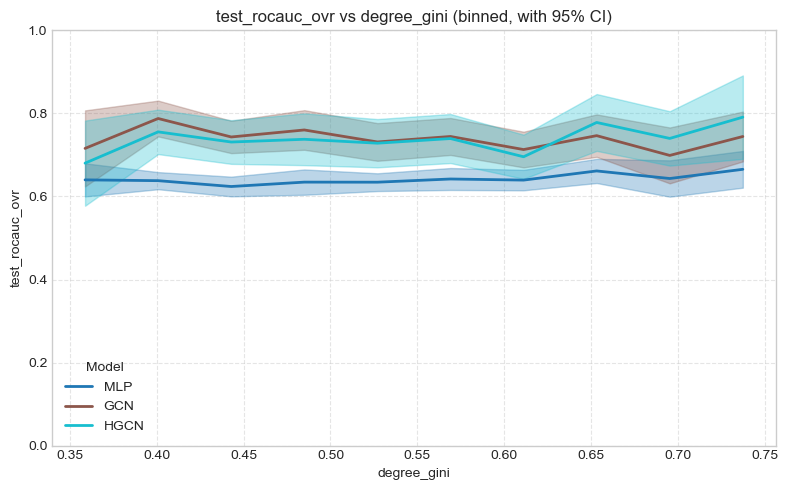

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

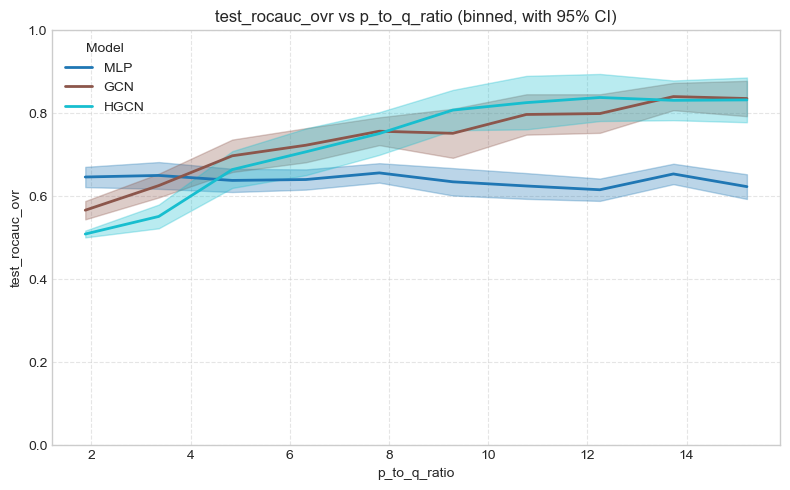

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

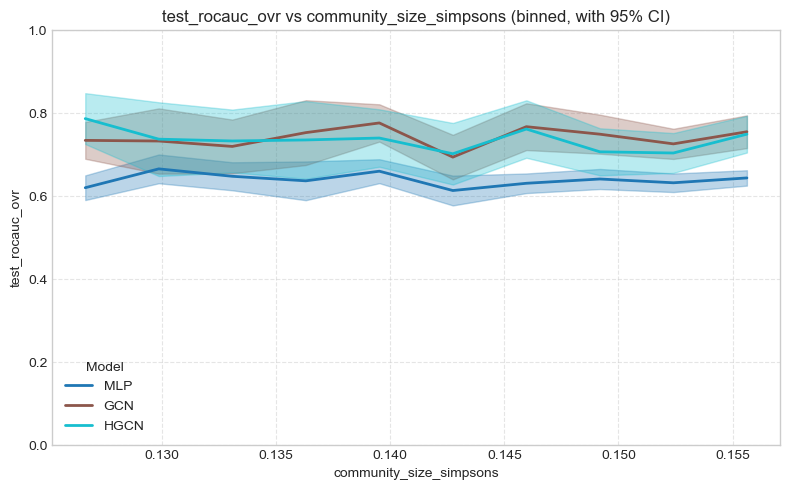

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

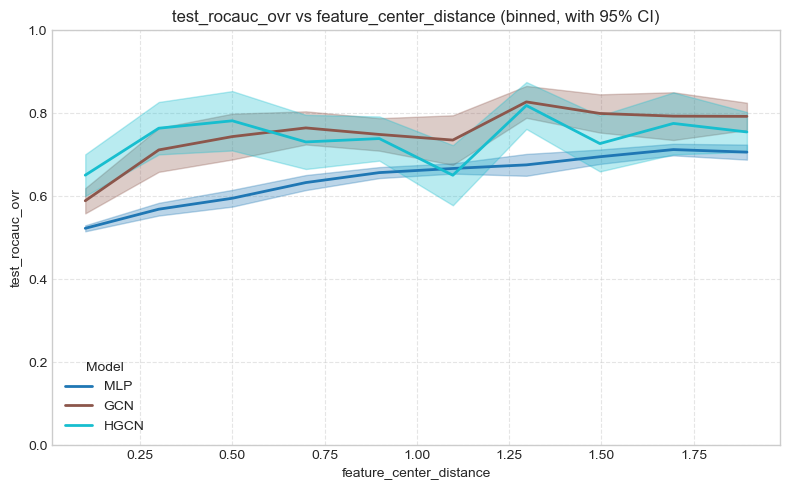

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

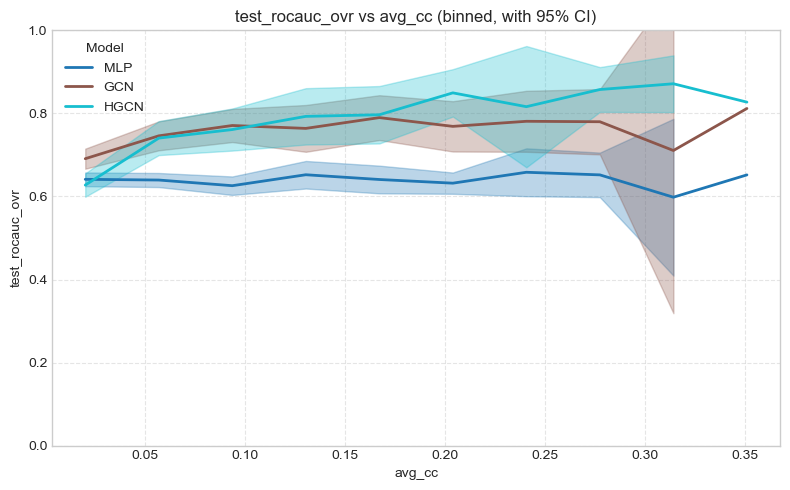

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

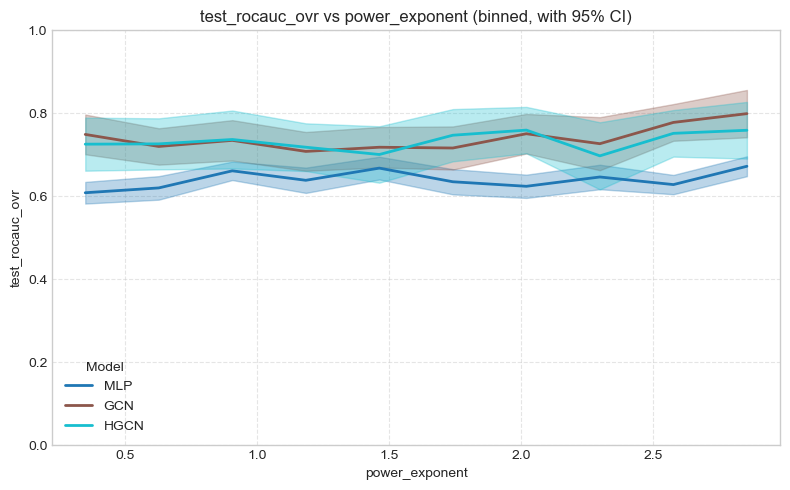

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

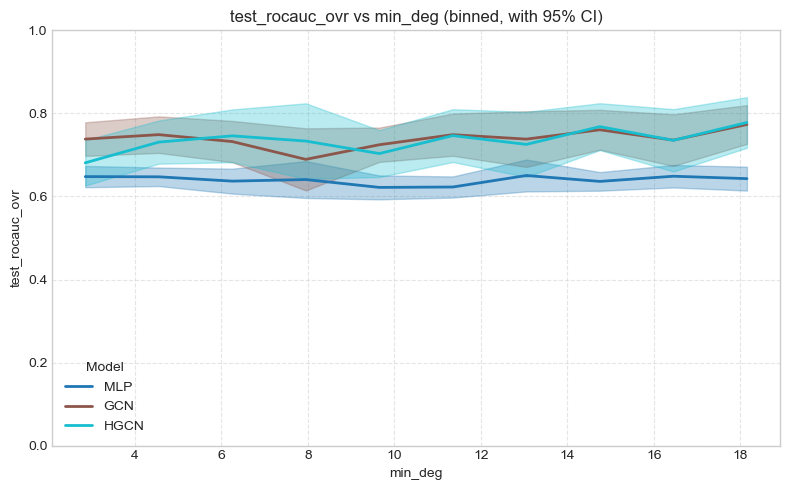

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)


In [ ]:
for m in graph_metrics_refined:
    smoothed_plot_perf_vs_metric(df[df['num_clusters'] == 8], models = ['MLP', 'GCN', 'HGCN'], perf_meas= 'test_rocauc_ovr', metric = m)

## FLAT FEAT FLAT COMMUNITIES

In [ ]:
## fixed parameter generation 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/fixed_gen_params/flat_graph_flat_feat'
df1 = df_gen(RESULTS_DIR + '/1')
df2 = df_gen(RESULTS_DIR + '/2')
df = pd.concat([df1,df2])
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,HGCN__model_c,HGCN__model_dropout,HGCN__model_hidden_channels,HGCN__model_in_channels,HGCN__model_lr,HGCN__model_num_layers,HGCN__model_weight_decay,HGCN__model_out_channels,HGCN__train_epochs,HGCN__train_patience
0,2000,9.358961,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.2,32,16,0.0020,1,0.0005,8,200,20
1,2000,9.684690,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.4,32,16,0.0005,2,0.0005,8,200,20
2,2000,8.924180,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.4,8,16,0.0005,2,0.0000,8,200,20
3,2000,9.455465,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.0,16,16,0.0010,2,0.0010,8,200,20
4,2000,9.454821,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.2,16,16,0.0020,2,0.0005,8,200,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2000,9.812406,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.2,16,16,0.0020,2,0.0010,8,200,20
496,2000,9.496222,0.8,16,1.0,1,3.0,8,0.0,2.5,...,NaN,0.2,32,16,0.0005,2,0.0001,8,200,20
497,2000,8.950485,0.8,16,1.0,1,3.0,8,0.0,2.5,...,2.0,0.0,32,16,0.0005,2,0.0001,8,200,20
498,2000,9.780684,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.0,8,16,0.0020,2,0.0001,8,200,20


In [ ]:
df[['edge_homogeneity', 'avg_degree']].describe()

,edge_homogeneity,avg_degree
count,500.000000,500.000000
mean,0.287285,9.453031
std,0.005084,0.233322
min,0.270983,8.486570
25%,0.283867,9.323551
50%,0.287625,9.478390
75%,0.290507,9.618871
max,0.304894,10.019105


In [6]:
def boxplot_three_models(df, metric):
    models = ['MLP', 'GCN', 'HGCN']
    df_temp = df[[f'{model}__{metric}' for model in models]]
    df_temp = df_temp.rename(columns = {f'{model}__{metric}':model for model in models})
    sns.boxplot(df_temp,
                palette='muted'
                )
    plt.ylabel(metric)
    plt.show()

boxplot_three_models(df, 'test_rocauc_ovr')

NameError: name 'df' is not defined

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


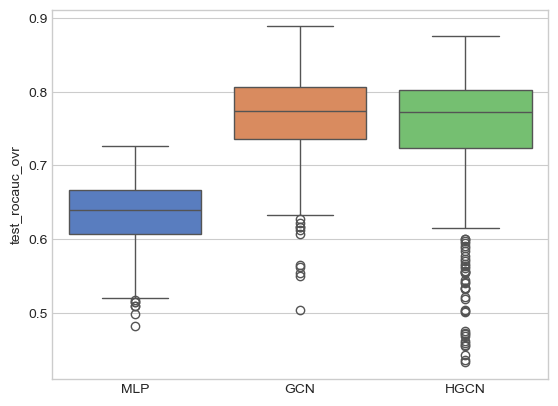

In [ ]:
## fixed parameter generation 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2'
df1 = df_gen(RESULTS_DIR + '/3')
df2 = df_gen(RESULTS_DIR + '/4') 
df = pd.concat([df1, df2])
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')

In [ ]:
df[[f'{model}__{metric}' for model in models]].describe()

,GCN__test_rocauc_ovr,MLP__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,500.000000,500.000000,500.000000
mean,0.765740,0.633354,0.748231
std,0.056239,0.046505,0.082270
min,0.503474,0.481587,0.432278
25%,0.735904,0.607398,0.724005
50%,0.773936,0.639528,0.772578
75%,0.806162,0.667155,0.803048
max,0.889261,0.726036,0.876643


In [ ]:
df[['edge_homogeneity', 'avg_degree']].describe()

,edge_homogeneity,avg_degree
count,500.000000,500.000000
mean,0.473136,9.233290
std,0.007281,0.276852
min,0.445229,8.280374
25%,0.468246,9.076341
50%,0.473251,9.267764
75%,0.478456,9.447711
max,0.496204,9.795156


# Calibration

In [38]:
# flat features flat graph 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'feature_center_distance', 'noise_var']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,feature_center_distance,noise_var
count,100.000000,100.000000,100.0,1.000000e+02
mean,0.472717,9.245281,1.5,1.000000e-01
std,0.006918,0.226881,0.0,2.789540e-17
min,0.452462,8.537988,1.5,1.000000e-01
25%,0.468583,9.152958,1.5,1.000000e-01
50%,0.471533,9.259265,1.5,1.000000e-01
75%,0.477542,9.397030,1.5,1.000000e-01
max,0.490177,9.633434,1.5,1.000000e-01


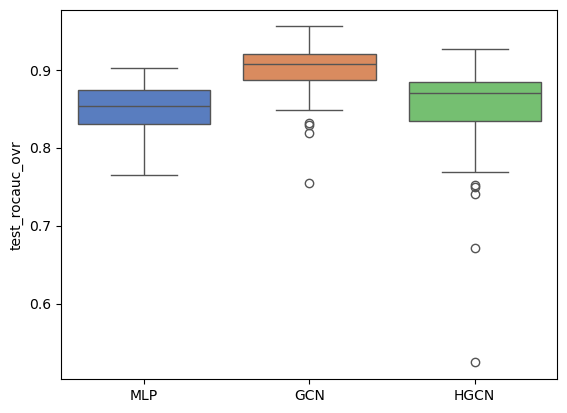

In [40]:
boxplot_three_models(df, metric = 'test_rocauc_ovr')

In [41]:
# flat features flat graph 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/calib'
df2 = df_gen(RESULTS_DIR + '/2')
df3 = df_gen(RESULTS_DIR + '/3')
df = pd.concat([df2,df3])
df = df.reset_index(drop=True)
df[['edge_homogeneity', 'avg_degree', 'feature_center_distance', 'noise_var']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_93259/465497905.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(dfs)


,edge_homogeneity,avg_degree,feature_center_distance,noise_var
count,100.000000,100.000000,100.0,1.000000e+02
mean,0.473092,9.255105,1.0,1.000000e-01
std,0.006937,0.241582,0.0,2.789540e-17
min,0.453264,8.627931,1.0,1.000000e-01
25%,0.468773,9.130026,1.0,1.000000e-01
50%,0.473498,9.305337,1.0,1.000000e-01
75%,0.477848,9.433608,1.0,1.000000e-01
max,0.489742,9.646643,1.0,1.000000e-01


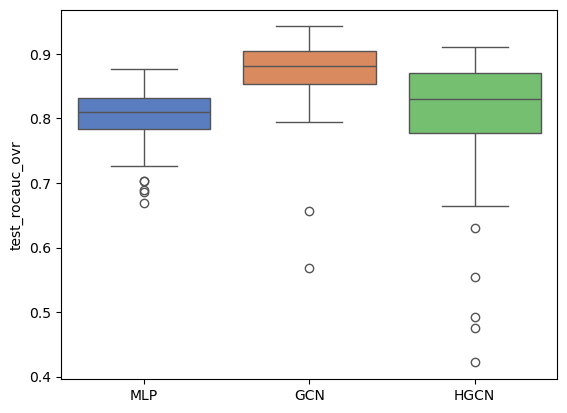

In [42]:
boxplot_three_models(df, metric = 'test_rocauc_ovr')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       edge_homogeneity  avg_degree  feature_center_distance     noise_var  \
count         50.000000   50.000000             5.000000e+01  5.000000e+01   
mean           0.472190    9.203736             3.000000e-01  1.000000e-01   
std            0.007012    0.259808             5.607473e-17  2.803737e-17   
min            0.457571    8.303992             3.000000e-01  1.000000e-01   
25%            0.468201    9.061687             3.000000e-01  1.000000e-01   
50%            0.471062    9.211248             3.000000e-01  1.000000e-01   
75%            0.477078    9.380725             3.000000e-01  1.000000e-01   
max            0.489776    9.719192             3.000000e-01  1.000000e-01  

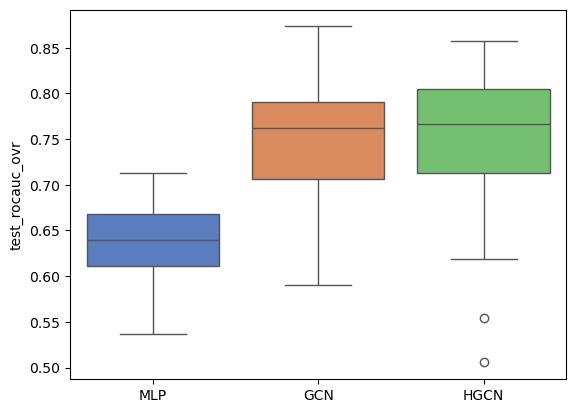

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       edge_homogeneity  avg_degree  feature_center_distance     noise_var  \
count         50.000000   50.000000             5.000000e+01  5.000000e+01   
mean           0.473381    9.254195             4.000000e-01  1.000000e-01   
std            0.007327    0.206394             1.121495e-16  2.803737e-17   
min            0.460578    8.685862             4.000000e-01  1.000000e-01   
25%            0.468514    9.167676             4.000000e-01  1.000000e-01   
50%            0.472795    9.262923             4.000000e-01  1.000000e-01   
75%            0.477638    9.386804             4.000000e-01  1.000000e-01   
max            0.489075    9.656739             4.000000e-01  1.000000e-01  

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_93259/465497905.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(dfs)


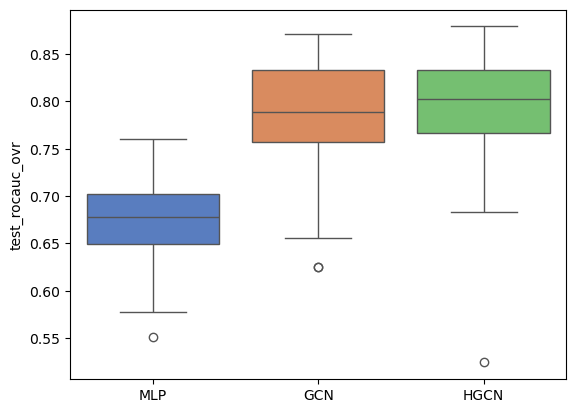

In [58]:
# flat features flat graph 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/calib'
for i in range(7,9):
    df = df_gen(RESULTS_DIR + f'/{i}')
    print(df[['edge_homogeneity', 'avg_degree', 'feature_center_distance', 'noise_var', 'GCN__test_rocauc_ovr', 'HGCN__test_rocauc_ovr', 'MLP__test_rocauc_ovr']].describe())
    boxplot_three_models(df, metric = 'test_rocauc_ovr')
    

## HSBM

In [ ]:
# here: p_inter_super=0.5, p_intra_sub=12.0, p_intra_super=4.0
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree
count,20.000000,20.000000
mean,0.440996,9.135278
std,0.004960,0.299276
min,0.434787,8.400208
25%,0.436348,8.984934
50%,0.439380,9.203453
75%,0.445861,9.339070
max,0.448469,9.529471


In [ ]:
# here: p_inter_super=0.5, p_intra_sub=20.0, p_intra_super=4.0
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/2'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree
count,20.000000,20.000000
mean,0.559314,9.003521
std,0.005982,0.312268
min,0.550571,8.365514
25%,0.554583,8.778414
50%,0.557477,9.062644
75%,0.563620,9.251074
max,0.572632,9.517939


In [ ]:
# here: p_inter_super=0.5, p_intra_sub=14.0, p_intra_super=4.0
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/3'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree
count,100.000000,100.000000
mean,0.478203,9.193496
std,0.007260,0.302139
min,0.455488,8.310133
25%,0.474111,9.040622
50%,0.479090,9.228354
75%,0.482607,9.408475
max,0.502968,9.793451


## Hierarchical feats 

In [7]:
# here: feature_center_distance = 0.8, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.473533,9.214894,0.588060
std,0.007455,0.236733,0.052759
min,0.458777,8.679918,0.489968
25%,0.468337,9.034892,0.553311
50%,0.474270,9.257839,0.589041
75%,0.478874,9.380688,0.626191
max,0.488817,9.633618,0.697678


In [8]:
# here: feature_center_distance = 1.0, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/2'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.473238,9.248688,0.597785
std,0.007399,0.247609,0.061150
min,0.457095,8.517683,0.473615
25%,0.469663,9.100571,0.553186
50%,0.472047,9.295228,0.595900
75%,0.478636,9.452081,0.634898
max,0.490504,9.592165,0.749326


In [9]:
# here: feature_center_distance = 1.3, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/3'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.474005,9.250459,0.605205
std,0.007201,0.199654,0.054013
min,0.461718,8.671843,0.473761
25%,0.468879,9.124826,0.571825
50%,0.473409,9.258344,0.609860
75%,0.479412,9.357162,0.637078
max,0.488362,9.719352,0.718675


In [ ]:
# here: feature_center_distance = 1.5, alpha = .8
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/5'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.474480,9.304677,0.621334
std,0.007283,0.231965,0.055827
min,0.459307,8.765521,0.505834
25%,0.470299,9.147691,0.577781
50%,0.474672,9.308175,0.620967
75%,0.479960,9.486485,0.662855
max,0.492032,9.798583,0.738505


In [ ]:
# here: feature_center_distance = 2.0, alpha = .9
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/4'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr
count,50.000000,50.000000,50.000000
mean,0.474649,9.329298,0.635184
std,0.007022,0.248565,0.051442
min,0.460339,8.405738,0.516828
25%,0.468860,9.204643,0.602997
50%,0.473550,9.380156,0.642835
75%,0.480999,9.464310,0.675947
max,0.487675,9.732529,0.714325


In [19]:
# here: feature_center_distance = 1.5, alpha = .8
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/6'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha
count,50.000000,50.000000,50.000000,50.0,5.000000e+01
mean,0.471308,9.197066,0.616655,1.5,8.000000e-01
std,0.007990,0.267075,0.063678,0.0,2.242989e-16
min,0.449860,8.362615,0.508544,1.5,8.000000e-01
25%,0.466178,9.015595,0.563052,1.5,8.000000e-01
50%,0.470851,9.203723,0.628648,1.5,8.000000e-01
75%,0.477682,9.418413,0.669122,1.5,8.000000e-01
max,0.484512,9.716448,0.737968,1.5,8.000000e-01


In [20]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/7'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha
count,50.000000,50.000000,50.000000,50.0,50.0
mean,0.471081,9.162553,0.632991,1.7,0.9
std,0.007642,0.278014,0.060149,0.0,0.0
min,0.446827,8.342174,0.498630,1.7,0.9
25%,0.467290,9.068135,0.579778,1.7,0.9
50%,0.472221,9.185762,0.647499,1.7,0.9
75%,0.474758,9.338381,0.676678,1.7,0.9
max,0.490038,9.686710,0.733808,1.7,0.9


In [39]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/calib/1/1'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha', 'GCN__test_rocauc_ovr_super']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_5214/465497905.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(dfs)


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha,GCN__test_rocauc_ovr_super
count,50.000000,50.000000,50.000000,5.000000e+01,50.0,0.0
mean,0.473172,9.240700,0.651559,7.000000e-01,0.9,NaN
std,0.008235,0.282087,0.087559,2.242989e-16,0.0,NaN
min,0.454173,8.276180,0.463335,7.000000e-01,0.9,NaN
25%,0.467839,9.164447,0.580939,7.000000e-01,0.9,NaN
50%,0.473115,9.302676,0.669329,7.000000e-01,0.9,NaN
75%,0.478714,9.447786,0.735413,7.000000e-01,0.9,NaN
max,0.491389,9.640664,0.773462,7.000000e-01,0.9,NaN


In [40]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/calib/2/2'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha', 'GCN__test_rocauc_ovr_super']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha,GCN__test_rocauc_ovr_super
count,50.000000,50.000000,50.000000,5.000000e+01,50.0,0.0
mean,0.471557,9.188509,0.685437,8.000000e-01,0.9,NaN
std,0.008465,0.252492,0.070194,2.242989e-16,0.0,NaN
min,0.453308,8.544898,0.521499,8.000000e-01,0.9,NaN
25%,0.466588,9.055372,0.647034,8.000000e-01,0.9,NaN
50%,0.472442,9.188956,0.700740,8.000000e-01,0.9,NaN
75%,0.477828,9.374004,0.739965,8.000000e-01,0.9,NaN
max,0.486574,9.615928,0.775805,8.000000e-01,0.9,NaN


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       MLP__test_rocauc_ovr  GCN__test_rocauc_ovr  HGCN__test_rocauc_ovr  \
count            100.000000            100.000000             100.000000   
mean               0.690727              0.746280               0.689840   
std                0.065932              0.052789               0.083887   
min                0.499305              0.524531               0.462696   
25%                0.656562              0.735254               0.659433   
50%                0.707135              0.760115               0.718281   
75%                0.738000              0.777217               0.749852   
max                0.780614              0.803822               0.798224   

       edge_hom

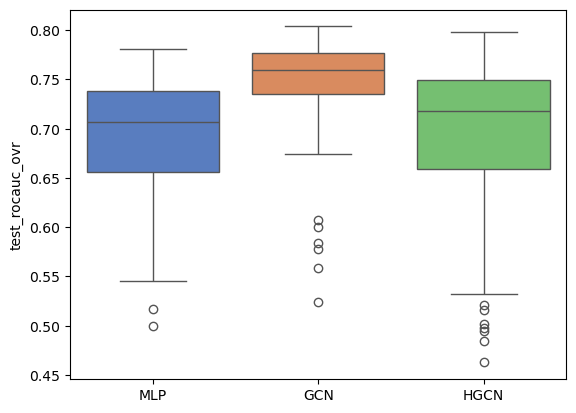

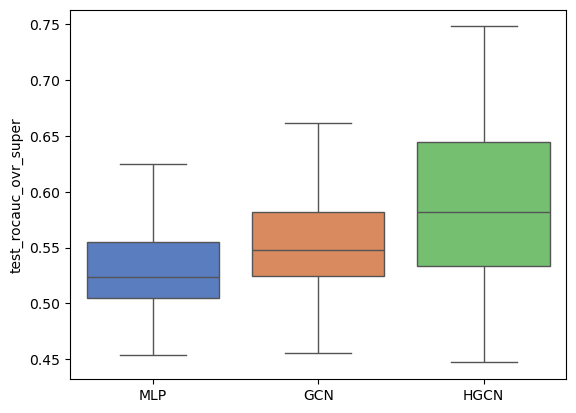

In [68]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/calib/3/3'
df = df_gen(RESULTS_DIR)
print(df[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe())
boxplot_three_models(df, 'test_rocauc_ovr')
boxplot_three_models(df, 'test_rocauc_ovr_super')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
       MLP__test_rocauc_ovr  GCN__test_rocauc_ovr  HGCN__test_rocauc_ovr  \
count            100.000000            100.000000             100.000000   
mean               0.696122              0.745981               0.688365   
std                0.067917              0.060163               0.088278   
min                0.500888              0.487440               0.431987   
25%                0.662423              0.742015               0.662947   
50%                0.718361              0.763920               0.718049   
75%                0.743016              0.778703               0.752141   
max                0.793757              0.812214               0.790844   

       edge_hom

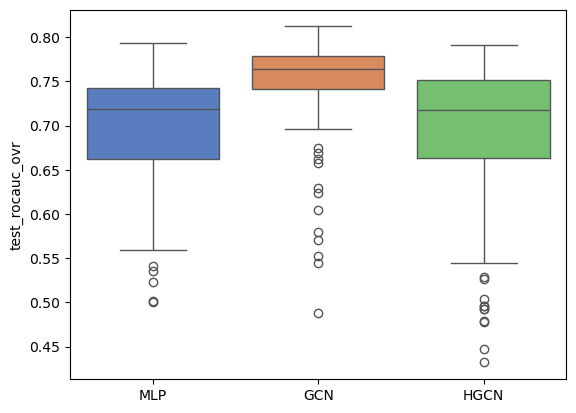

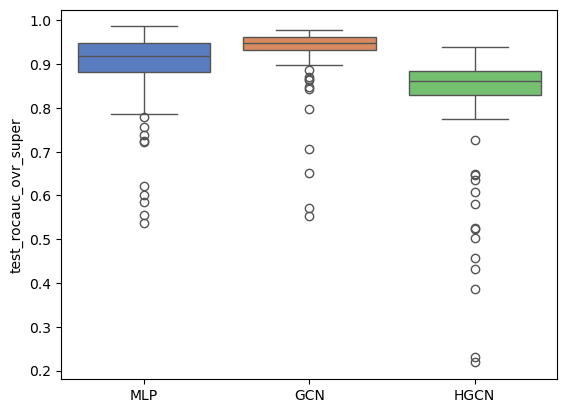

In [74]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/calib/4'
df = df_gen(RESULTS_DIR)
print(df[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe())
boxplot_three_models(df, 'test_rocauc_ovr')
boxplot_three_models(df, 'test_rocauc_ovr_super')

## Both

In [21]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_hier/5'
df = df_gen(RESULTS_DIR)
df[['edge_homogeneity', 'avg_degree', 'MLP__test_rocauc_ovr', 'feature_center_distance', 'alpha']].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,edge_homogeneity,avg_degree,MLP__test_rocauc_ovr,feature_center_distance,alpha
count,60.000000,60.000000,60.000000,60.0,60.0
mean,0.472213,9.215430,0.641591,1.7,0.9
std,0.007185,0.276783,0.065016,0.0,0.0
min,0.456900,8.656090,0.502705,1.7,0.9
25%,0.467648,9.023134,0.597761,1.7,0.9
50%,0.472237,9.237161,0.654686,1.7,0.9
75%,0.476375,9.444588,0.692229,1.7,0.9
max,0.493326,9.667338,0.747605,1.7,0.9


In [30]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_rocauc_ovr'

# Main runs I

## Hier community main exp

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


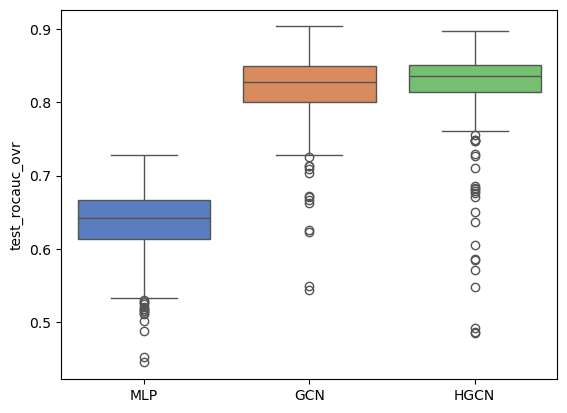

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,500.000000,500.000000,500.000000
mean,0.635937,0.821994,0.824954
std,0.045248,0.042181,0.049407
min,0.445452,0.544159,0.485790
25%,0.613336,0.800876,0.813785
50%,0.642143,0.828111,0.835623
75%,0.666665,0.849195,0.851383
max,0.728818,0.903292,0.897542


In [31]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]].describe()

## Hier feat main exp

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

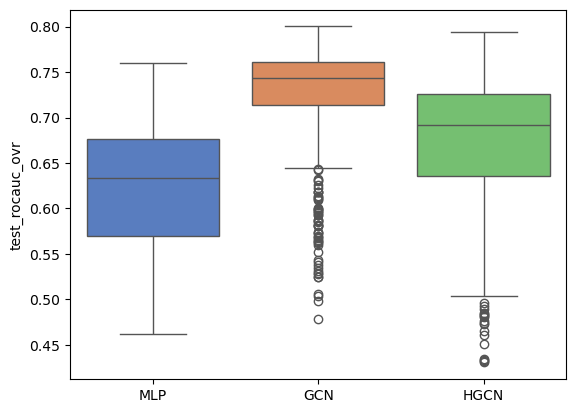

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,500.000000,500.000000,500.000000
mean,0.623843,0.723127,0.670946
std,0.065850,0.061206,0.074936
min,0.461837,0.478409,0.430471
25%,0.569589,0.714146,0.635722
50%,0.633285,0.743444,0.691662
75%,0.676345,0.760834,0.726113
max,0.759943,0.800151,0.793561


In [32]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/main_run'
dfs = []
for i in range(1,6):
    df = df_gen(RESULTS_DIR+f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]].describe()

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


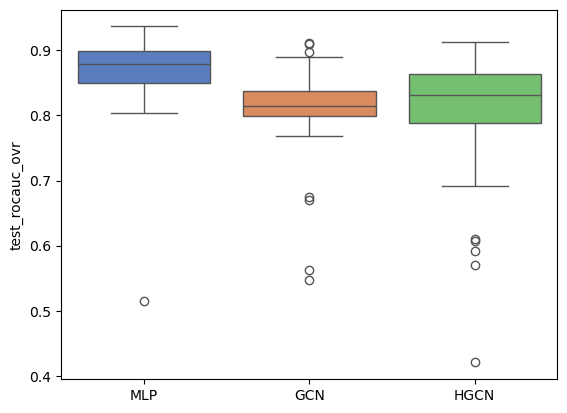

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr
count,100.000000,100.000000,100.000000
mean,0.872901,0.813217,0.814673
std,0.047607,0.052223,0.079081
min,0.514680,0.546690,0.420526
25%,0.849621,0.799066,0.788820
50%,0.878865,0.813996,0.831734
75%,0.898865,0.837432,0.863946
max,0.936694,0.910721,0.912187


In [36]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/no_noise/no_noise/1'
df = df_gen(RESULTS_DIR)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]].describe()

## Both hier main exp

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


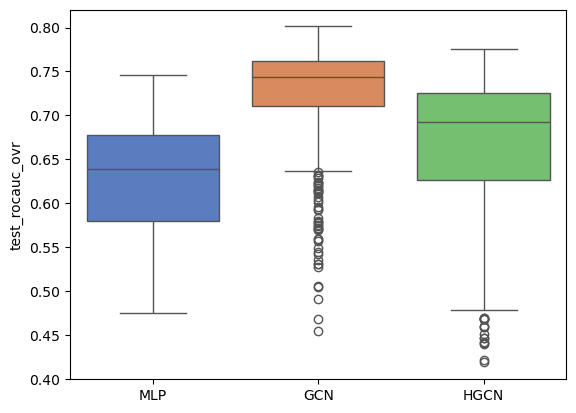

In [24]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_hier/main_run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR+f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')

# Main runs II

## Both flat

In [145]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_rocauc_ovr'

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


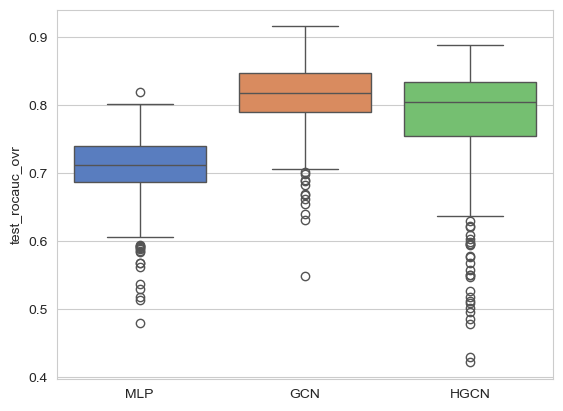

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr,edge_homogeneity,avg_degree,feature_center_distance,alpha
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,5.000000e+02
mean,0.708434,0.814603,0.782994,0.473430,9.239962,0.5,9.000000e-01
std,0.046133,0.046537,0.077112,0.007152,0.250653,0.0,2.222670e-16
min,0.480238,0.548770,0.421729,0.449212,8.417987,0.5,9.000000e-01
25%,0.686462,0.790550,0.754812,0.468911,9.086106,0.5,9.000000e-01
50%,0.712428,0.818527,0.805272,0.473851,9.272635,0.5,9.000000e-01
75%,0.739595,0.847778,0.834169,0.477988,9.423047,0.5,9.000000e-01
max,0.819602,0.915797,0.888522,0.491948,9.805737,0.5,9.000000e-01


In [146]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_flat/main_run/main_run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df_bl = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df_bl[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe()

## Hierarchical features

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


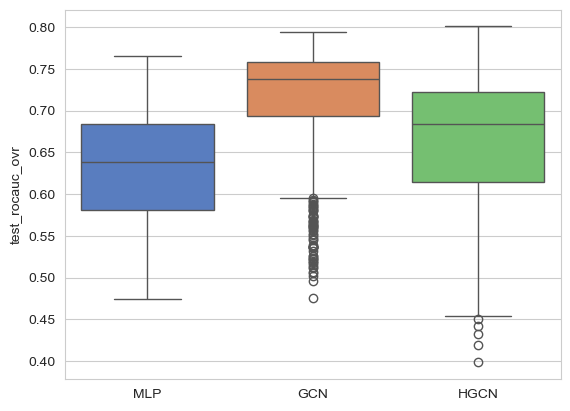

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr,edge_homogeneity,avg_degree,feature_center_distance,alpha
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,5.000000e+02
mean,0.629722,0.710856,0.661319,0.473615,9.250360,0.5,9.000000e-01
std,0.067764,0.070793,0.079453,0.007241,0.249720,0.0,2.222670e-16
min,0.474104,0.475485,0.398285,0.444294,8.060482,0.5,9.000000e-01
25%,0.580477,0.693299,0.614058,0.468666,9.107217,0.5,9.000000e-01
50%,0.638778,0.737162,0.683936,0.473707,9.280767,0.5,9.000000e-01
75%,0.684102,0.758522,0.721894,0.478482,9.435510,0.5,9.000000e-01
max,0.765014,0.794372,0.800614,0.495664,9.811055,0.5,9.000000e-01


In [147]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/main_run/main_run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df_hf = df.reset_index(drop=True)
boxplot_three_models(df_hf, 'test_rocauc_ovr')
df_hf[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe()


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


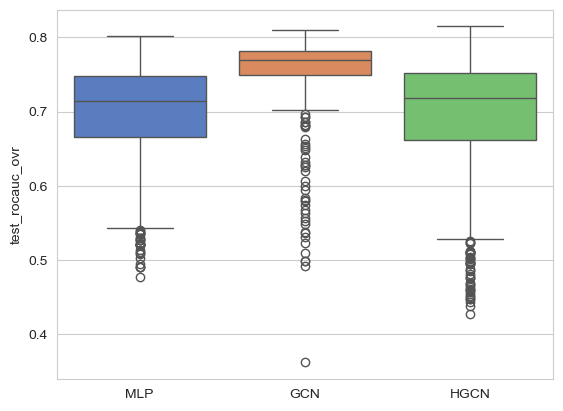

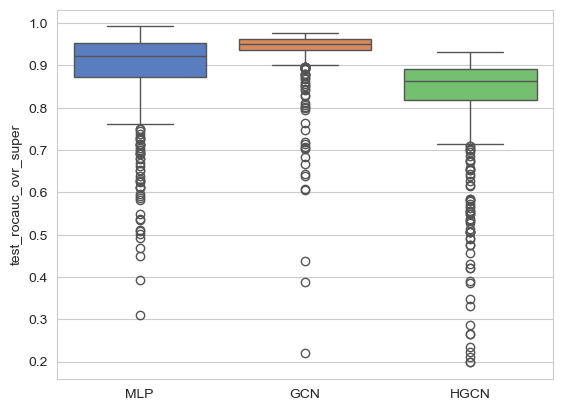

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr,edge_homogeneity,avg_degree,feature_center_distance,alpha
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,5.000000e+02
mean,0.696437,0.753481,0.689659,0.473059,9.234725,1.0,9.000000e-01
std,0.069081,0.054347,0.086557,0.007489,0.269458,0.0,2.222670e-16
min,0.476834,0.361627,0.426986,0.451139,8.228629,1.0,9.000000e-01
25%,0.665746,0.748949,0.661614,0.468157,9.075746,1.0,9.000000e-01
50%,0.713770,0.768937,0.718492,0.473276,9.270700,1.0,9.000000e-01
75%,0.748148,0.781442,0.751534,0.478354,9.435507,1.0,9.000000e-01
max,0.801894,0.810620,0.814717,0.494102,9.831156,1.0,9.000000e-01


In [174]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/main_run/'
dfs = []
for i in range(1,2):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df_hf_v2 = df.reset_index(drop=True)
boxplot_three_models(df_hf_v2, 'test_rocauc_ovr')
boxplot_three_models(df_hf_v2, 'test_rocauc_ovr_super')
df_hf_v2[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe()

## HSBM

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


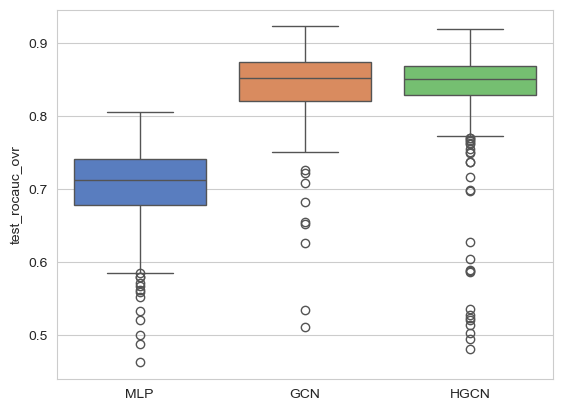

       MLP__test_rocauc_ovr  GCN__test_rocauc_ovr  HGCN__test_rocauc_ovr  \
count            500.000000            500.000000             500.000000   
mean               0.705220              0.844626               0.839730   
std                0.050020              0.045418               0.058232   
min                0.462448              0.510334               0.481281   
25%                0.678201              0.820736               0.828953   
50%                0.712059              0.851350               0.850564   
75%                0.740612              0.874031               0.868530   
max                0.804601              0.922213               0.918748   

       edge_homogeneity  avg_degree  feature_center_distance         alpha  
count        500.000000  500.000000                    500.0  5.000000e+02  
mean           0.477525    9.175135                      0.5  9.000000e-01  
std            0.006693    0.285574                      0.0  2.222670e-16  
min    

In [144]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hsbm/main_run/main_run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df_hc = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
print(df_hc[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe())
print('--- FLAGS ----')
print(df_hc[['hsbm', 'hier_feats', 'noisy_feats']])

## Both hier 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


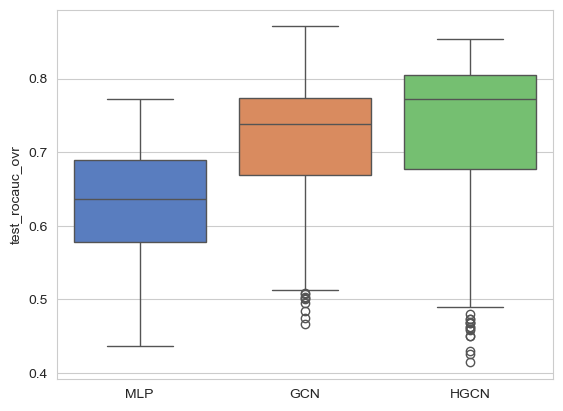

       MLP__test_rocauc_ovr  GCN__test_rocauc_ovr  HGCN__test_rocauc_ovr  \
count            500.000000            500.000000             500.000000   
mean               0.632215              0.716920               0.727290   
std                0.069323              0.081505               0.107817   
min                0.436688              0.466882               0.414286   
25%                0.578431              0.668408               0.676631   
50%                0.636882              0.737642               0.771989   
75%                0.689115              0.773241               0.805163   
max                0.771589              0.870693               0.853840   

       edge_homogeneity  avg_degree  feature_center_distance         alpha  
count        500.000000  500.000000                    500.0  5.000000e+02  
mean           0.477319    9.142193                      0.5  9.000000e-01  
std            0.006721    0.275748                      0.0  2.222670e-16  
min    

In [154]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_hier/main_run/main_run'
dfs = []
for i in range(1,3):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df_bh = df.reset_index(drop=True)
metric = 'test_rocauc_ovr'
boxplot_three_models(df_bh, 'test_rocauc_ovr')
print(df_bh[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha', 'hsbm', 'hier_feats']].describe())
print('--- FLAGS ----')
print(df_bh[['hsbm', 'hier_feats', 'noisy_feats']])

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


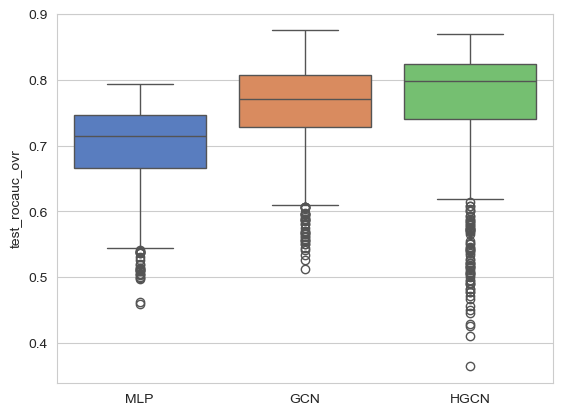

       MLP__test_rocauc_ovr  GCN__test_rocauc_ovr  HGCN__test_rocauc_ovr  \
count            500.000000            500.000000             500.000000   
mean               0.695308              0.755868               0.755849   
std                0.070097              0.074163               0.104977   
min                0.459695              0.512292               0.364572   
25%                0.665371              0.727594               0.741154   
50%                0.714636              0.771432               0.798772   
75%                0.747020              0.806706               0.824544   
max                0.793837              0.874938               0.869102   

       edge_homogeneity  avg_degree  feature_center_distance         alpha  
count        500.000000  500.000000                    500.0  5.000000e+02  
mean           0.477393    9.166810                      1.0  9.000000e-01  
std            0.006025    0.262029                      0.0  2.222670e-16  
min    

In [173]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/both_hier/main_run/main_run'
dfs = []
for i in range(3,5):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df_bh_v2 = df.reset_index(drop=True)
metric = 'test_rocauc_ovr'
boxplot_three_models(df_bh_v2, 'test_rocauc_ovr')
print(df_bh_v2[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha', 'hsbm', 'hier_feats']].describe())
print('--- FLAGS ----')
print(df_bh_v2[['hsbm', 'hier_feats', 'noisy_feats']])

## Analysis of graph metrics across ablations

In [156]:
sanity_cols = [
    'feature_center_distance',
    'noise_var',
    'hsbm',
    'hier_feats',
    'noisy_feats',
    'alpha'
]

dfs   = [df_bl, df_hc, df_hf, df_bh]
names = ["Baseline", "Hier. Comm.", "Hier. Feats", "Both Hier."]

# 1) Select columns that actually exist
cols_present = [c for c in sanity_cols if c in dfs[0].columns]
dfs = [d[cols_present] for d in dfs]

# 2) Build a tidy summary: mean, std, (min,max) or IQR if you prefer
def summarize(df):
    return pd.concat([
        df.mean().rename("mean"),
        df.std().rename("std"),
        df.min().rename("min"),
        df.max().rename("max")
    ], axis=1)

summary_tables = {name: summarize(d) for name, d in zip(names, dfs)}

# 3) Concatenate for side-by-side comparison
summary_all = pd.concat(summary_tables, axis=1)  # MultiIndex columns

print(summary_all.round(3).to_string())

                        Baseline                    Hier. Comm.                    Hier. Feats                    Both Hier.                 
                            mean  std    min    max        mean  std    min    max        mean  std    min    max       mean  std   min   max
feature_center_distance      0.5  0.0    0.5    0.5         0.5  0.0    0.5    0.5         0.5  0.0    0.5    0.5        0.5  0.0   0.5   0.5
noise_var                    0.1  0.0    0.1    0.1         0.1  0.0    0.1    0.1         0.1  0.0    0.1    0.1        0.1  0.0   0.1   0.1
hsbm                         0.0  0.0  False  False         1.0  0.0   True   True         0.0  0.0  False  False        1.0  0.0  True  True
hier_feats                   0.0  0.0  False  False         0.0  0.0  False  False         1.0  0.0   True   True        1.0  0.0  True  True
noisy_feats                  1.0  0.0   True   True         1.0  0.0   True   True         1.0  0.0   True   True        1.0  0.0  True  True
alpha 

In [159]:
must_match_cols = [
    "num_nodes",          # or "nvertex"
    "num_edges",
    "edge_density",
    "avg_degree",         # or "avg_degree_est"
    "edge_homogeneity",
    "p_to_q_ratio_est",   # or "p_to_q_ratio__est_dc"
    "num_clusters",
    "community_size_simpsons",
    "cluster_size_slope",
]

dfs   = [df_bl, df_hc, df_hf, df_bh]
names = ["Baseline", "Hier. Comm.", "Hier. Feats", "Both Hier."]

# 1) Select columns that actually exist
cols_present = [c for c in must_match_cols if c in dfs[0].columns]
dfs = [d[cols_present] for d in dfs]

# 2) Build a tidy summary: mean, std, (min,max) or IQR if you prefer
def summarize(df):
    return pd.concat([
        df.mean().rename("mean"),
        df.std().rename("std"),
    ], axis=1)

summary_tables = {name: summarize(d) for name, d in zip(names, dfs)}

# 3) Concatenate for side-by-side comparison
summary_all = pd.concat(summary_tables, axis=1)  # MultiIndex columns

print(summary_all.round(3).to_string())


                          Baseline          Hier. Comm.          Hier. Feats          Both Hier.         
                              mean      std        mean      std        mean      std       mean      std
num_nodes                 1973.168   10.113    1973.658   10.443    1973.396   10.796   1972.696   10.676
num_edges                18233.796  563.279   18110.804  636.188   18256.592  567.788  18036.864  615.615
edge_density                 0.005    0.000       0.005    0.000       0.005    0.000      0.005    0.000
avg_degree                   9.240    0.251       9.175    0.286       9.250    0.250      9.142    0.276
edge_homogeneity             0.473    0.007       0.478    0.007       0.474    0.007      0.477    0.007
p_to_q_ratio_est            12.592    0.360      12.800    0.342      12.602    0.365     12.789    0.344
num_clusters                 8.000    0.000       8.000    0.000       8.000    0.000      8.000    0.000
community_size_simpsons      0.125    0.000   

In [158]:
tier2_cols = [
    "degree_gini", "pareto_exponent",
    "coreness_eq_1", "coreness_geq_2", "coreness_geq_5", "coreness_geq_10", "coreness_gini",
    "avg_cc", "transitivity", "num_triangles", "power_law_estimate"
]

dfs   = [df_bl, df_hc, df_hf, df_bh]
names = ["Baseline", "Hier. Comm.", "Hier. Feats", "Both Hier."]

# Keep only columns present
tier2 = [c for c in tier2_cols if c in df_bl.columns]
dfs_sel = [d[tier2] for d in dfs]

base_mean = dfs_sel[0].mean()
tol = 0.05  # 5% band

def summarize(d):
    return pd.DataFrame({
        "mean": d.mean(),
        "std": d.std(),
    })

summaries = {n: summarize(d) for n, d in zip(names, dfs_sel)}
summary_all = pd.concat(summaries, axis=1)

# Percent deviation from baseline means
dev_tables = {}
for n, d in zip(names[1:], dfs_sel[1:]):
    dev = ((d.mean() - base_mean) / base_mean).abs()*100
    dev_tables[n] = dev.sort_values(ascending=False)

dev_df = pd.concat(dev_tables, axis=1)  # columns = conditions

print(summary_all.round(3))
print("\n% deviation from baseline means (absolute):")
print(dev_df.round(2))
print(f"\nMetrics exceeding {tol*100:.0f}% deviation in any condition:")
print(dev_df[dev_df.gt(tol*100).any(axis=1)])

                    Baseline          Hier. Comm.          Hier. Feats  \
                        mean      std        mean      std        mean   
degree_gini            0.512    0.018       0.507    0.017       0.511   
pareto_exponent        0.567    0.020       0.567    0.020       0.567   
coreness_eq_1          0.049    0.013       0.049    0.012       0.049   
coreness_geq_2         0.951    0.013       0.951    0.012       0.951   
coreness_geq_5         0.530    0.040       0.532    0.042       0.533   
coreness_geq_10        0.024    0.022       0.015    0.019       0.025   
coreness_gini          0.255    0.019       0.250    0.018       0.254   
avg_cc                 0.087    0.024       0.101    0.026       0.086   
transitivity           0.040    0.004       0.047    0.004       0.040   
num_triangles       4725.332  997.030    5132.994  846.886    4713.606   
power_law_estimate     1.786    0.031       1.786    0.032       1.785   

                            Both Hier

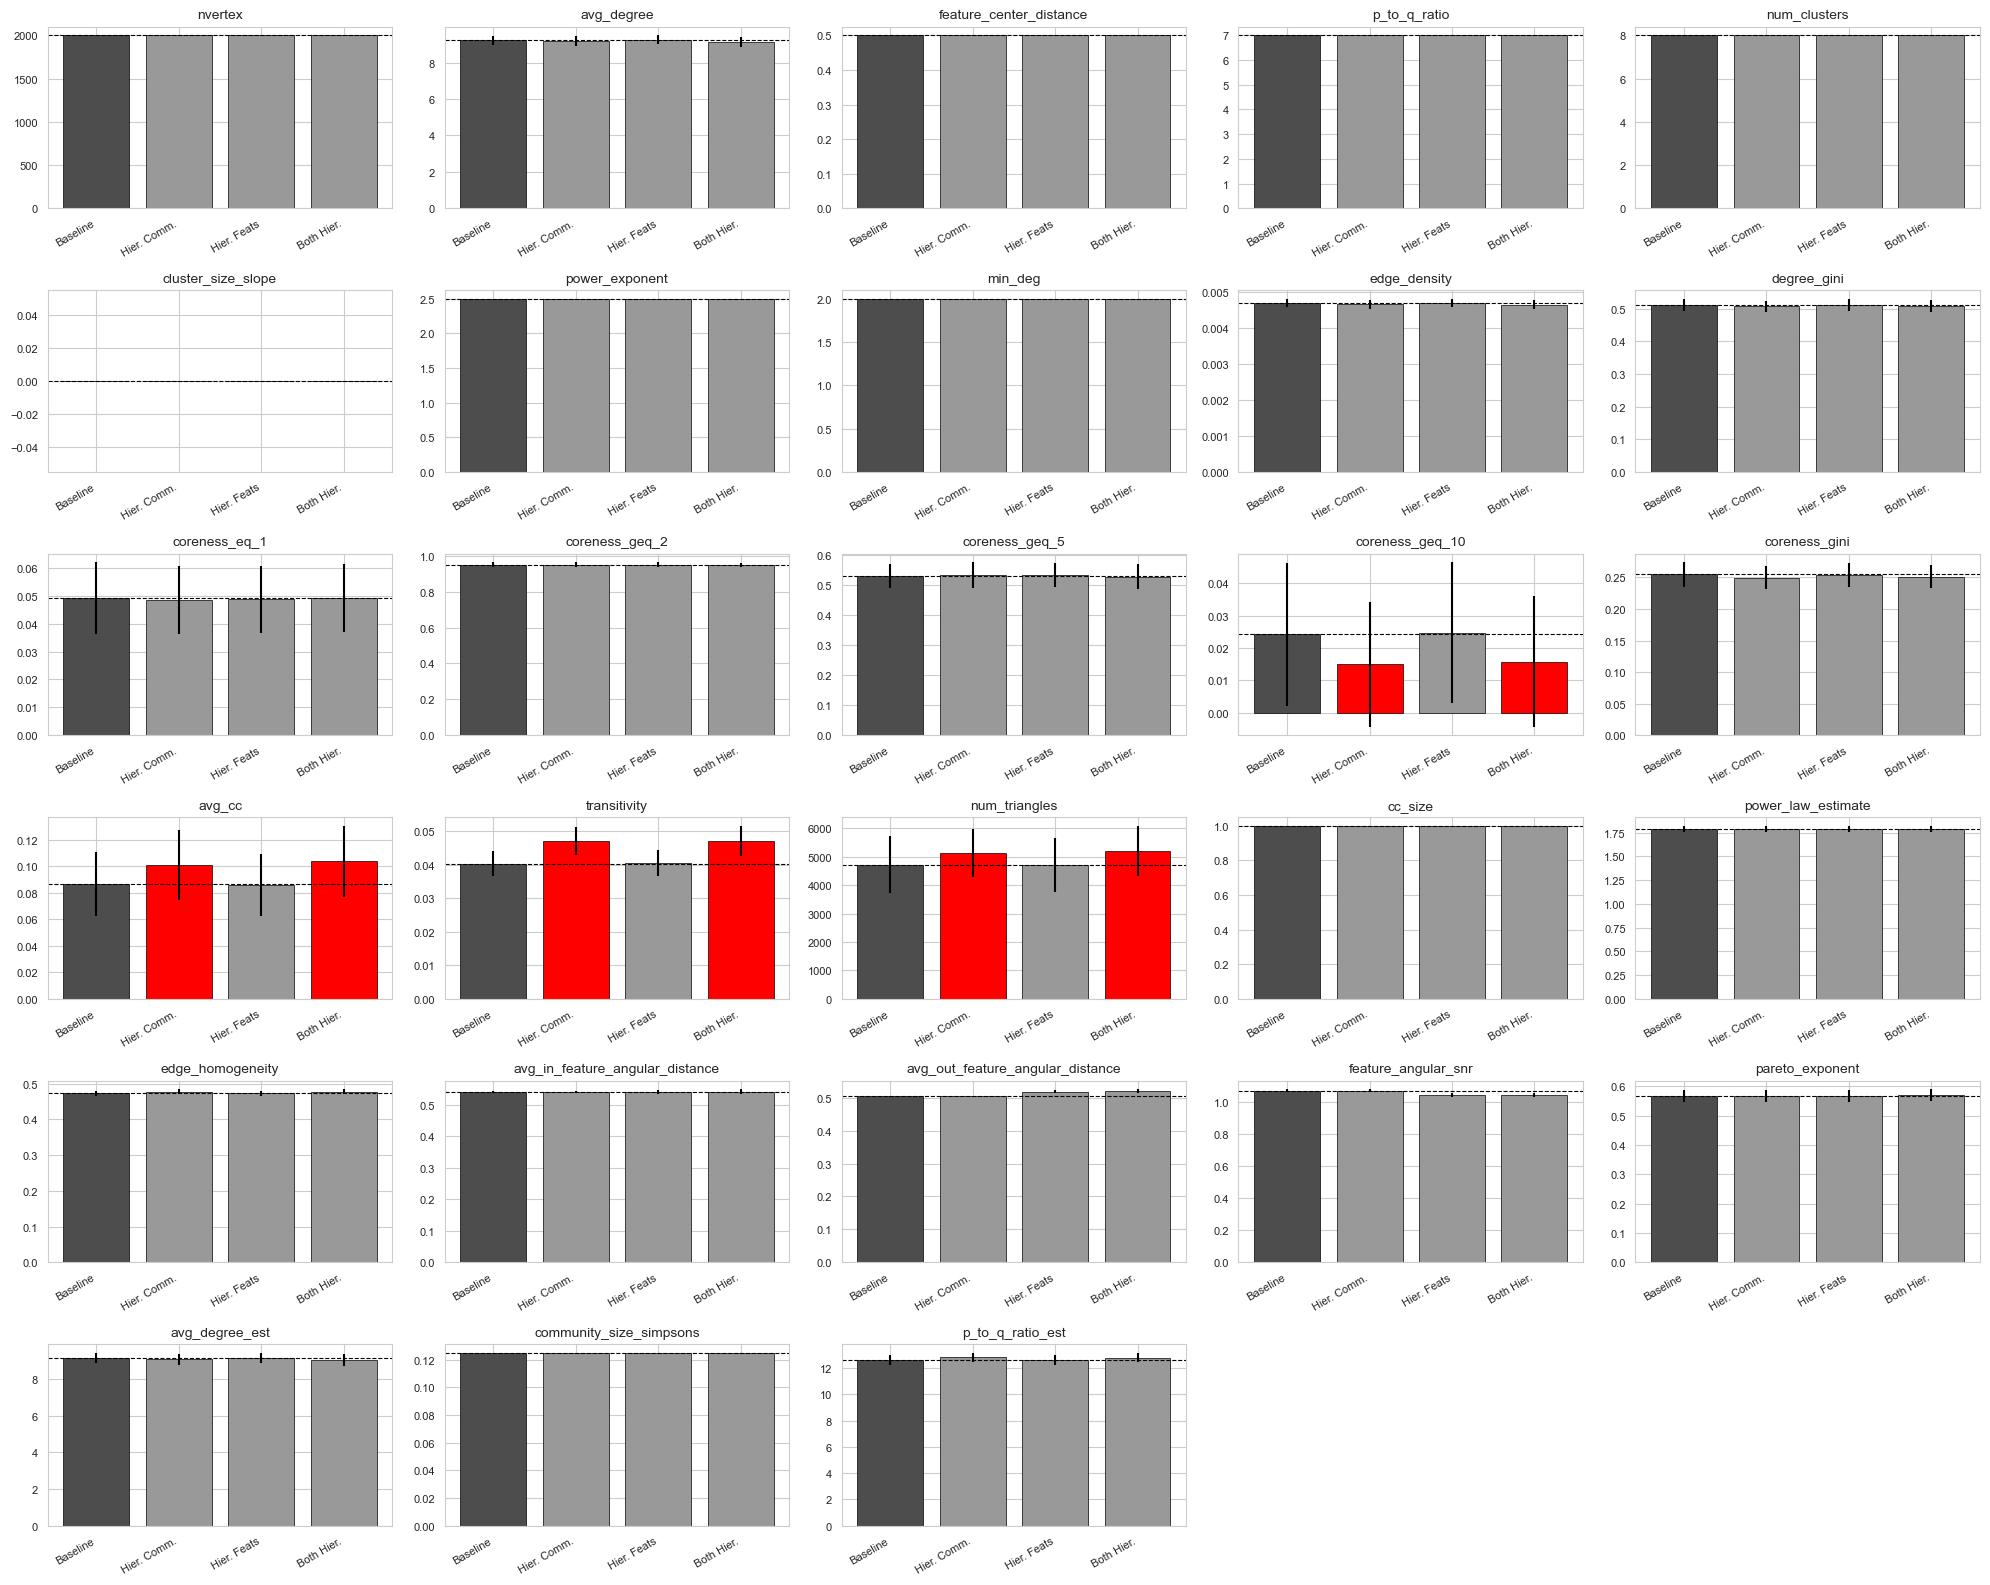

In [166]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- inputs -----------------
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est']

dfs   = [df_bl, df_hc, df_hf, df_bh]
names = ["Baseline", "Hier. Comm.", "Hier. Feats", "Both Hier."]

# keep only columns that exist
cols = [c for c in graph_metrics if c in dfs[0].columns]
dfs_sel = [d[cols] for d in dfs]

# compute stats
means = [d.mean() for d in dfs_sel]
stds  = [d.std()  for d in dfs_sel]
base_mean = means[0]
tol = 0.05  # 5% threshold for red coloring

# ----------------- plotting -----------------
n_metrics = len(cols)
n_cols = 5
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.8*n_rows), squeeze=False)
axes = axes.flatten()

for i, metric in enumerate(cols):
    ax = axes[i]
    vals = [m[metric] for m in means]
    errs = [s[metric] for s in stds]
    # color rule: red if |val - baseline| / baseline > tol (and not Baseline)
    colors = []
    for j, v in enumerate(vals):
        if j == 0:
            colors.append("0.3")
        else:
            dev = abs(v - vals[0]) / (abs(vals[0]) + 1e-12)
            colors.append("red" if dev > tol else "0.6")
    ax.bar(range(len(names)), vals, yerr=errs, color=colors, edgecolor="black", linewidth=0.5)
    ax.axhline(vals[0], color="black", linestyle="--", linewidth=0.8)  # baseline mean
    ax.set_title(metric, fontsize=10)
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=30, ha="right", fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

# hide extras
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# fig.suptitle("Computed Graph Metrics: Mean Values per Condition\n(red bars = >5% from Baseline mean)", fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("tier2_values_grid.png", dpi=300)
plt.show()


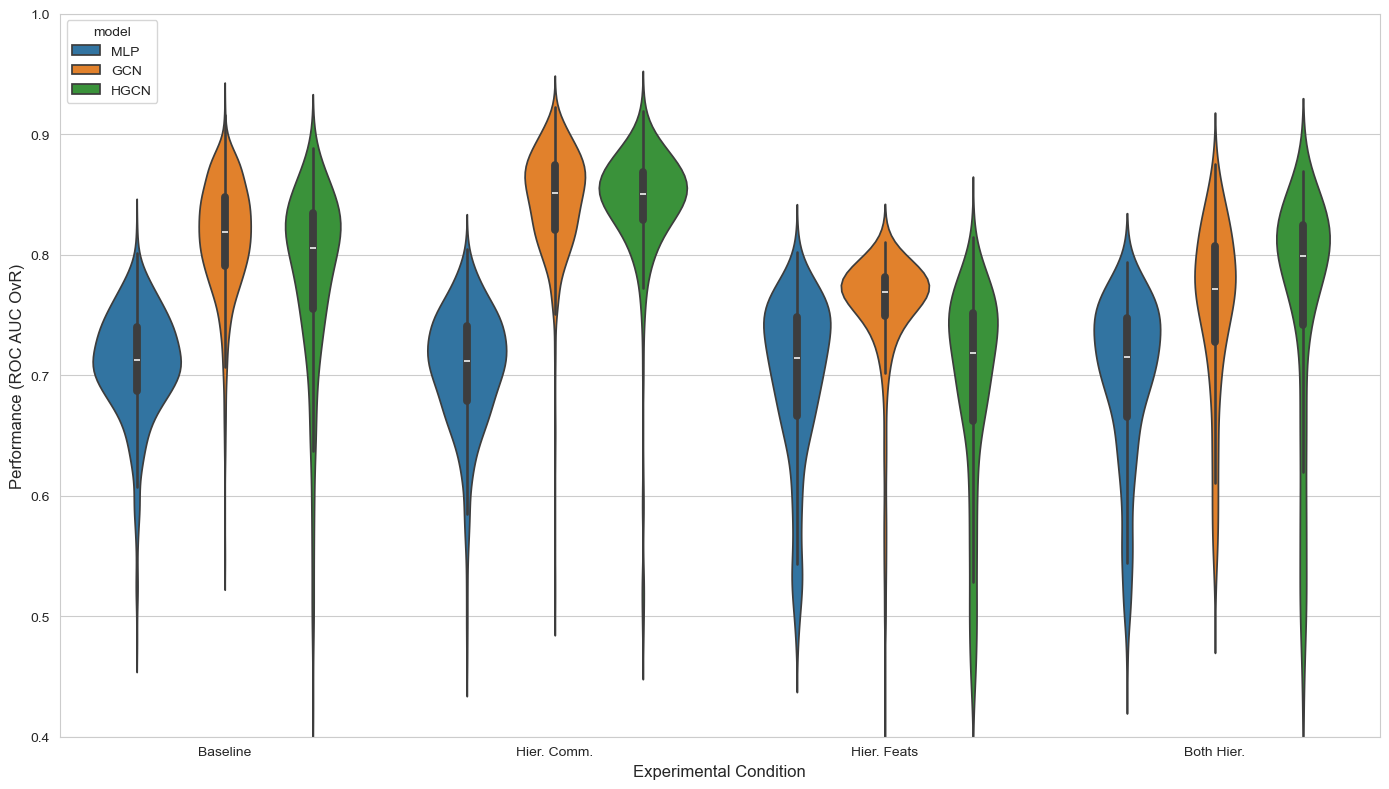

In [176]:
tidy_dfs = []
dfs   = [df_bl, df_hc, df_hf_v2, df_bh_v2]
names = ["Baseline", "Hier. Comm.", "Hier. Feats", "Both Hier."]
metric = 'test_rocauc_ovr'
for df, name in zip(dfs, names):
    # Melt the DataFrame from wide to long format
    df = df[[f'{model}__{metric}' for model in models]]
    df_melted = df.melt(var_name='model_metric', value_name='performance')
    
    # Split the 'model_metric' column into 'model' and 'metric'
    df_melted[['model', 'metric']] = df_melted['model_metric'].str.split('__', expand=True)
    
    # Add the condition name
    df_melted['condition'] = name
    tidy_dfs.append(df_melted)

# Concatenate all tidy DataFrames into one
full_df = pd.concat(tidy_dfs, ignore_index=True)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

sns.violinplot(
    data=full_df,
    x='condition',
    y='performance',
    hue='model',
    inner='box'
)

plt.ylim(0.4, 1.0)
# plt.title('Model Performance Distributions Across Experimental Conditions', fontsize=16)
plt.xlabel('Experimental Condition', fontsize=12)
plt.ylabel('Performance (ROC AUC OvR)', fontsize=12)
plt.tight_layout()
plt.savefig("performance_violins_adjusted.png", dpi=300)
plt.show()

## Varying alpha in hierarchical feature space

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

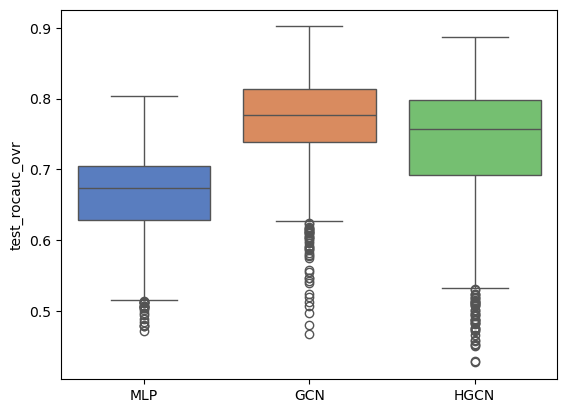

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr,edge_homogeneity,avg_degree,feature_center_distance,alpha
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,0.661615,0.768148,0.734828,0.472962,9.236726,0.5,0.491508
std,0.061284,0.065273,0.090005,0.007127,0.253935,0.0,0.286665
min,0.472227,0.467956,0.427197,0.451850,8.196586,0.5,0.001160
25%,0.628616,0.738507,0.691712,0.468596,9.088897,0.5,0.240802
50%,0.674218,0.777170,0.756966,0.473247,9.271396,0.5,0.484048
75%,0.704597,0.813680,0.798485,0.477448,9.417929,0.5,0.745271
max,0.803524,0.902014,0.887488,0.495596,9.814982,0.5,0.998296


In [31]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/vary_alpha/vary_alpha'
dfs = []
for i in range(1,5):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe()

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_5214/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_5214/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_5214/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence

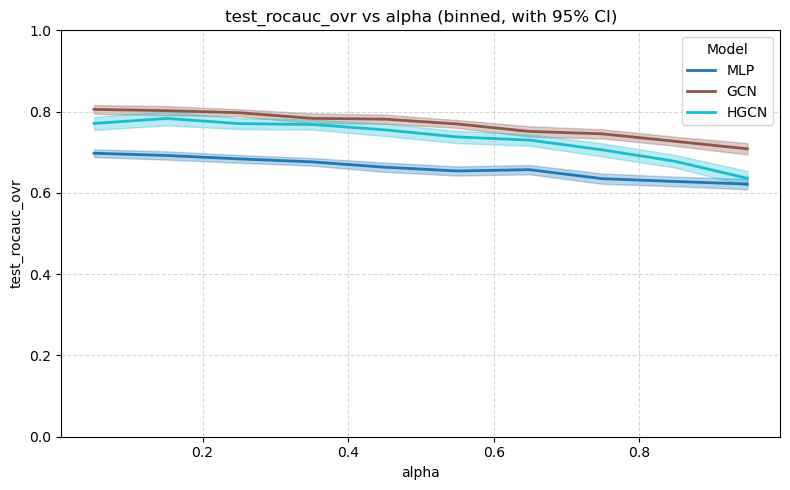

In [34]:
smoothed_plot_perf_vs_metric(df, models, perf_meas = 'test_rocauc_ovr', metric='alpha')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


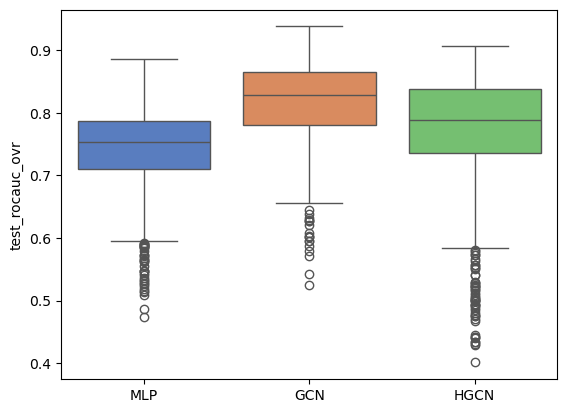

,MLP__test_rocauc_ovr,GCN__test_rocauc_ovr,HGCN__test_rocauc_ovr,edge_homogeneity,avg_degree,feature_center_distance,alpha
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,0.743589,0.820799,0.771358,0.472808,9.237176,1.0,0.502095
std,0.064908,0.061376,0.091331,0.007417,0.251738,0.0,0.286736
min,0.473096,0.525297,0.400882,0.446543,8.117220,1.0,0.003026
25%,0.709757,0.780322,0.735971,0.467883,9.086336,1.0,0.252436
50%,0.754073,0.828309,0.789154,0.473092,9.266363,1.0,0.507512
75%,0.787539,0.864913,0.838404,0.477817,9.416425,1.0,0.755542
max,0.885822,0.938350,0.907407,0.493169,9.804730,1.0,0.998272


In [77]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/hier_feats/vary_alpha'
dfs = []
for i in range(3,5):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
boxplot_three_models(df, 'test_rocauc_ovr')
df[[f'{model}__{metric}' for model in models]+['edge_homogeneity', 'avg_degree','feature_center_distance', 'alpha']].describe()

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_5214/1923091224.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


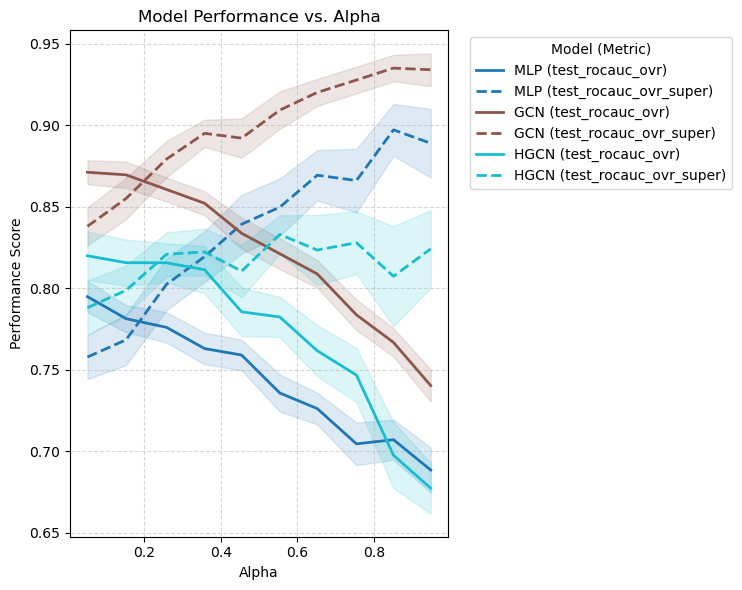

In [85]:
smoothed_plot_multiple_perfs_vs_metric(df, models, perf_measures = ['test_rocauc_ovr', 'test_rocauc_ovr_super'], metric='alpha')